In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random

from itertools import combinations
from time import time

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn.functional as F

from scipy import stats

from procyon.data.data_utils import DATA_DIR
from procyon.data.inference_utils import (
    create_batched_input_retrieval,
    create_input_retrieval,
    get_proteins_from_batched_embeddings,
    get_proteins_from_embedding,
)
from procyon.evaluate.framework.args import EvalArgs
from procyon.model.model_unified import UnifiedProCyon

%matplotlib inline

[2025-03-05 10:10:28,679] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


# Load pre-trained model

In [3]:
# Make sure this line runs, follow instructions in GitHub to set HOME_DIR
HOME_DIR = os.getenv("HOME_DIR")
print(HOME_DIR)

/n/home08/rcalef/sandbox/repos/ProCyon


In [4]:
# Replace with the path where you downloaded a pre-trained ProCyon model (e.g. ProCyon-Full)
checkpoint_path = "~/storage/Lab/PLM/huggingface_repos/ProCyon-Full"
CKPT_NAME = os.path.expanduser(checkpoint_path)

In [5]:
# Loading the model and transitioning to device:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model, _ = UnifiedProCyon.from_pretrained(checkpoint_dir=CKPT_NAME)
model.bfloat16() # Quantize the model to a smaller precision
model.eval()
model.to(device)

updating model args DATA_DIR from /n/holystore01/LABS/mzitnik_lab/Lab/PLM -> /n/holylfs06/LABS/mzitnik_lab/Lab/PLM/huggingface_repos/ProCyon-Instruct
updating stale DATA_DIR for model arg: go_embeddings_path
updating stale DATA_DIR for model arg: pfam_embeddings_path
updating stale DATA_DIR for model arg: drugbank_embeddings_path
updating stale DATA_DIR for model arg: reactome_embeddings_path
updating stale DATA_DIR for model arg: omim_embeddings_path
updating stale DATA_DIR for model arg: ec_embeddings_path
updating stale DATA_DIR for model arg: protein_seq_embeddings_path
updating stale DATA_DIR for model arg: protein_struct_embeddings_path
updating stale DATA_DIR for model arg: protein_embeddings_idmap_path
updating stale DATA_DIR for model arg: drug_struct_embeddings_path
updating stale DATA_DIR for model arg: domain_embeddings_path
updating stale DATA_DIR for model arg: domain_embeddings_idmap_path
updating stale DATA_DIR for model arg: mouse_ortholog_embeddings_path
updating stal

Using sep_token, but it is not set yet.
Using pad_token, but it is not set yet.


Processing zero checkpoint '/n/home08/rcalef/storage/Lab/PLM/huggingface_repos/ProCyon-Full/global_step59469'
Detected checkpoint of type zero stage 2, world_size: 32
Parsing checkpoint created by deepspeed==0.12.4
Reconstructed fp32 state dict with 322 params 8141117441 elements


UnifiedProCyon(
  (text_encoder): LlamaPostTokenization(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128263, 4096)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
              (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
              (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (rotary_emb): LlamaRotaryEmbedding()
            )
            (mlp): LlamaMLP(
              (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
              (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
              (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
              (act_fn): SiLUActivation()
            )
     

In [5]:
data_args = torch.load(os.path.join(CKPT_NAME, "data_args.pt"))
train_args = torch.load(os.path.join(CKPT_NAME, "training_args.pt"))

In [6]:
# Load saved embeddings for this model:
all_protein_embeddings, all_protein_ids = torch.load(os.path.join(CKPT_NAME, "protein_target_embeddings.pkl"))
# Confirm with size:
print(all_protein_embeddings.shape)
assert np.all(np.array(all_protein_ids) == np.sort(np.array(all_protein_ids)))

torch.Size([18174, 2560])


In [10]:
# Note that running with ProtST requires installing an environment compatible
# with the ProtST model (see README on the `protst_benchmarking` branch).
regenerate_protst = True

if regenerate_protst:
    from procyon.evaluate.framework.protst import ProtSTRetrievalEval

    protst_model = ProtSTRetrievalEval(
        model_config={},
        eval_args=EvalArgs(retrieval_use_cached_target_embeddings=True, batch_size=16),
        model_args=None,
        device=device,
    )

Some weights of the model checkpoint at /n/holylfs06/LABS/mzitnik_lab/Lab/PLM/huggingface_repos/ProCyon-Instruct/model_weights/pubmedbert-abs/BiomedNLP-BiomedBERT-base-uncased-abstract were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
# Load saved embeddings for this model:
protst_protein_embeddings, protst_protein_ids = torch.load(os.path.join(
    protst_model.checkpoint_dir,
    "protein_target_embeddings.pkl",
))
# Confirm with size:
print(protst_protein_embeddings.shape)
assert np.all(np.array(protst_protein_ids) == np.sort(np.array(protst_protein_ids)))
assert np.all(np.sort(np.array(protst_protein_ids)) == np.sort(np.array(all_protein_ids)))

torch.Size([18174, 512])


In [12]:
composition_dir = os.path.join(
    DATA_DIR,
    "experimental_data",
    "compositional_prompts",
)

def composition_path(fn: str) -> str:
    return os.path.join(composition_dir, fn)

integrated_data_dir = os.path.join(
    DATA_DIR,
    "integrated_data",
    "v1",
)
go_ancestors = torch.load(os.path.join(
    integrated_data_dir,
    "go",
    "go_ancestors_dist.pkl",
))
go_info = pd.read_pickle(os.path.join(
    integrated_data_dir,
    "go",
    "go_info_filtered_composed.pkl",
))
protein_go_relations = pd.read_csv(os.path.join(
    integrated_data_dir,
    "protein_go",
    "sample_aware_ontology_go_centric",
    "protein_go_relations.unified.csv",
))
protein_info = pd.read_pickle(os.path.join(
    integrated_data_dir,
    "protein",
    "protein_info_filtered.pkl",
))

go_proteins = protein_go_relations[["text_id", "seq_id", "text_type"]].groupby("text_id").agg(set)
go_proteins["text_type"] = go_proteins["text_type"].apply(lambda st: list(st)[0])

# Signaling pathway crosstalks

In [13]:
go_procs = go_proteins.query("text_type == 'Process'").index
go_procs = go_info.set_index("go_id").loc[go_procs]
print(go_procs.shape)

go_procs_proteins = go_proteins.loc[go_procs.index]

(3242, 11)


In [14]:
crosstalk = (
    pd.read_csv(composition_path("crosstalk.csv")).
    query("Crosstalk == 'yes'").
    query("Species == 'Homo sapiens'").
    dropna(subset=["Molecule A Identifier", "Molecule B Identifier"], how="all")
)
crosstalk.groupby(by=["Pathway A", "Pathway B"]).agg(list)

Pubmed Query  \
Pathway A              Pathway B                                                                         
Adherens junction      Apoptosis                                          [Adherens Apoptosis pathway]   
                       ErbB signaling pathway        [Adherens AND ErbB AND pathway, Adherens AND W...   
                       Estrogen signaling pathway                  [Adherens AND Estrogen AND pathway]   
                       Hippo signaling pathway                        [Hippo AND Adherens AND pathway]   
                       MAPK signaling pathway                          [Adherens AND MAPK AND pathway]   
...                                                                                                ...   
mTOR signaling pathway Insulin signaling pathway                              [mTOR Insulin Crosstalk]   
                       Jak-STAT signaling pathway                            [mTOR Jak-STAT Crosstalk]   
                       MAPK signaling pathway                                    [mTOR MAPK Crosstalk]   
                       Melanogenesis                 [Melanogenesis mTOR Pathway, mTOR AND Melanoge...   
                       NF-kappa B signaling pathway                  [NF-kappa B AND mTOR AND pathway]   

                                                                     PMID  \
Pathway A              Pathway B                                            
Adherens junction      Apoptosis                               [25488805]   
                       ErbB signaling pathway        [17593333, 21939503]   
                       Estrogen signaling pathway              [21051859]   
                       Hippo signaling pathway                 [24532814]   
                       MAPK signaling pathway                  [10969083]   
...                                                                   ...   
mTOR signaling pathway Insulin signaling pathway               [25961241]   
                       Jak-STAT signaling pathway              [10660304]   
                       MAPK signaling pathway                  [24509877]   
                       Melanogenesis                 [22577264, 22577264]   
                       NF-kappa B signaling pathway            [23538752]   

                                                      Crosstalk  \
Pathway A              Pathway B                                  
Adherens junction      Apoptosis                          [yes]   
                       ErbB signaling pathway        [yes, yes]   
                       Estrogen signaling pathway         [yes]   
                       Hippo signaling pathway            [yes]   
                       MAPK signaling pathway             [yes]   
...                                                         ...   
mTOR signaling pathway Insulin signaling pathway          [yes]   
                       Jak-STAT signaling pathway         [yes]   
                       MAPK signaling pathway             [yes]   
                       Melanogenesis                 [yes, yes]   
                       NF-kappa B signaling pathway       [yes]   

                                                    Transcriptional  \
Pathway A              Pathway B                                      
Adherens junction      Apoptosis                               [no]   
                       ErbB signaling pathway        [unknown, yes]   
                       Estrogen signaling pathway             [yes]   
                       Hippo signaling pathway                 [no]   
                       MAPK signaling pathway                  [no]   
...                                                             ...   
mTOR signaling pathway Insulin signaling pathway              [yes]   
                       Jak-STAT signaling pathway              [no]   
                       MAPK signaling pathway                  [no]   
                       Melanogenesis                    

In [15]:
np.unique(crosstalk[["Pathway A", "Pathway B"]].values.flatten())

array(['Adherens junction', 'Adipocytokine signaling pathway',
       'Apoptosis', 'ErbB signaling pathway',
       'Estrogen signaling pathway', 'GnRH signaling pathway',
       'HIF-1 signaling pathway', 'Hedgehog signaling pathway',
       'Hippo signaling pathway', 'Insulin secretion pathway',
       'Insulin signaling pathway', 'Jak-STAT signaling pathway',
       'MAPK signaling pathway', 'Melanogenesis',
       'NF-kappa B signaling pathway', 'Neurotrophin signaling pathway',
       'Notch signaling pathway',
       'Progesterone-mediated oocyte maturation',
       'Prolactin signaling pathway', 'TGF-beta signaling pathway',
       'TNF signaling pathway', 'Thyroid hormone synthesis',
       'Toll-like receptor signaling pathway', 'VEGF signaling pathway',
       'Wnt signaling pathway', 'mTOR signaling pathway'], dtype=object)

In [16]:
pathway_go_dict = {
    "Notch signaling pathway":"GO:0007219",  # Notch signaling pathway
    "TGF-beta signaling pathway":"GO:0007179",  # transforming growth factor beta receptor signaling pathway
    "Jak-STAT signaling pathway":"GO:0007259",  # receptor signaling pathway via JAK-STAT
    "TNF signaling pathway":"GO:0033209",  # tumor necrosis factor-mediated signaling pathway
    "Wnt signaling pathway":"GO:0016055",  # Wnt signaling pathway
    "mTOR signaling pathway":"GO:0031929",  # TOR signaling
    "Toll-like receptor signaling pathway":"GO:0002224",  # toll-like receptor signaling pathway
    "VEGF signaling pathway":"GO:0038084",  # vascular endothelial growth factor signaling pathway
    "NF-kappa B signaling pathway":"GO:0007249",  # I-kappaB kinase/NF-kappaB signaling
    "MAPK signaling pathway":"GO:0000165",  # MAPK cascade
    "Adherens junction":"GO:0034332",  # adherens junction organization
    "ErbB signaling pathway":"GO:0038127",  # ERBB signaling pathway
    "Estrogen signaling pathway":"GO:0030520",  # intracellular estrogen receptor signaling pathway
    "Hedgehog signaling pathway":"GO:0007224",  # smoothened signaling pathway
    "Hippo signaling pathway":"GO:0035329",  # hippo signaling
    "Insulin signaling pathway":"GO:0008286",  # insulin receptor signaling pathway
}

In [17]:
valid_pathway_combos = {}
for pathway_1, pathway_2 in combinations(list(pathway_go_dict.keys()), 2):
    crosstalk_mediators = list(set([
        prot for prot in
        crosstalk.query(
            "(`Pathway B` == @pathway_1 and `Pathway A` == @pathway_2) or \
            (`Pathway A` == @pathway_1 and `Pathway B` == @pathway_2)"
        )[["Molecule A Identifier", "Molecule B Identifier"]].values.flatten()
        if prot == prot and prot in set(protein_info["protein_id"].values)
    ]))
    if len(crosstalk_mediators) > 0:
        valid_pathway_combos[(pathway_1, pathway_2)] = len(crosstalk_mediators)

In [18]:
# average number of proteins annotated with both
np.mean(list(valid_pathway_combos.values()))

2.8095238095238093

In [22]:
pathway_1, pathway_2 = next(iter(valid_pathway_combos.keys()))
pathway_1

'Notch signaling pathway'

In [23]:
num_icl = 0
pathway_go_1 = pathway_go_dict[pathway_1]
pathway_go_2 = pathway_go_dict[pathway_2]

# Examine whether pathway cross talks is annotated in GO
pathway_1_prots = go_procs_proteins.loc[pathway_go_1, "seq_id"]
pathway_2_prots = go_procs_proteins.loc[pathway_go_2, "seq_id"]

# Surprisingly, TGFB1 is somehow filtered from the protein list...
crosstalk_mediators = list(set([
    prot for prot in
    crosstalk.query(
        "(`Pathway B` == @pathway_1 and `Pathway A` == @pathway_2) or \
        (`Pathway A` == @pathway_1 and `Pathway B` == @pathway_2)"
    )[["Molecule A Identifier", "Molecule B Identifier"]].values.flatten()
    if prot == prot and prot in set(protein_info["protein_id"].values)
]))
print(len(crosstalk_mediators))

input_desc_1 = go_procs.loc[pathway_go_1, 'go_def']
input_desc_2 = go_procs.loc[pathway_go_2, 'go_def']

# Composition query
task_def = "You will be shown descriptions of two signaling pathways. Your job is to retrieve a protein that is involved in the crosstalk between the two pathways. Crosstalk refers to the case where one or more components of one signaling pathway affects the other."

input_desc = input_desc_1 + "\n" + input_desc_2
input_simple = create_input_retrieval(
    input_description = input_desc,
    data_args=data_args,
    task_definition = task_def,
    instruction_source_dataset = "go",
    instruction_source_relation = "process",
    aaseq_type = "protein",
    icl_example_number = num_icl,
)


8


In [25]:
print(input_desc)

The series of molecular signals initiated by an extracellular ligand binding to the receptor Notch on the surface of a target cell, and ending with the regulation of a downstream cellular process, e.g. transcription.
The series of molecular signals initiated by an extracellular ligand binding to a transforming growth factor beta receptor on the surface of a target cell, and ending with the regulation of a downstream cellular process, e.g. transcription.


In [26]:
check_embed = protst_model._get_text_embedding([input_desc])
check_embed.shape

torch.Size([1, 512])

In [30]:
check_embed.device

device(type='cpu')

In [28]:
protst_protein_embeddings

tensor([[ 7.7969e-03,  4.3408e-02, -1.4036e-02,  ..., -7.0473e-02,
          9.5514e-04, -3.9478e-02],
        [ 9.4380e-03,  5.8458e-02, -1.2641e-02,  ..., -3.1874e-02,
          9.6362e-03, -5.7582e-02],
        [ 6.1884e-03,  5.6582e-02,  1.0297e-04,  ..., -4.4310e-02,
          1.8526e-03, -3.8294e-02],
        ...,
        [-6.9121e-02,  3.0753e-02, -1.4957e-02,  ..., -1.1634e-01,
         -1.9177e-03,  7.4332e-02],
        [ 3.6294e-02, -2.5817e-02, -1.4791e-02,  ..., -6.0777e-02,
          2.2162e-03,  1.1806e-01],
        [ 1.9374e-02, -5.8638e-02, -1.4843e-03,  ..., -1.8940e-02,
          3.4737e-02, -7.3082e-03]])

In [31]:
check_df = get_proteins_from_embedding(
    protein_embeds=protst_protein_embeddings,
    query_embeddings=check_embed,
    top_k=None,
).set_index("uniprot_id")
check_df.head()

,name,sim_score
uniprot_id,,
P25092,"GUCY2C {ECO:0000303|PubMed:22521417, ECO:00003...",0.508376
P51841,GUCY2F,0.495324
Q7RTX0,TAS1R3,0.482956
P20594,NPR2,0.482156
P17342,NPR3,0.481060


The following will take a while (~10mins) to run due to the large number of model queries. For this reason, we've made the cached data available within ProCyon-Instruct, but feel free to set `regenerate_data` to True if you'd like to rerun from scratch

In [33]:
regenerate_data = False

if regenerate_data:
    all_plot_data_among_all = {}
    composite_embeddings = {}
    individual_embeddings = {}

    num_icl = 0

    for pathway_1, pathway_2 in valid_pathway_combos.keys():
        pathway_go_1 = pathway_go_dict[pathway_1]
        pathway_go_2 = pathway_go_dict[pathway_2]

        # Examine whether pathway cross talks is annotated in GO
        pathway_1_prots = go_procs_proteins.loc[pathway_go_1, "seq_id"]
        pathway_2_prots = go_procs_proteins.loc[pathway_go_2, "seq_id"]

        # Surprisingly, TGFB1 is somehow filtered from the protein list...
        crosstalk_mediators = list(set([
            prot for prot in
            crosstalk.query(
                "(`Pathway B` == @pathway_1 and `Pathway A` == @pathway_2) or \
                (`Pathway A` == @pathway_1 and `Pathway B` == @pathway_2)"
            )[["Molecule A Identifier", "Molecule B Identifier"]].values.flatten()
            if prot == prot and prot in set(protein_info["protein_id"].values)
        ]))
        print(len(crosstalk_mediators))

        input_desc_1 = go_procs.loc[pathway_go_1, 'go_def']
        input_desc_2 = go_procs.loc[pathway_go_2, 'go_def']

        # Composition query
        task_def = "You will be shown descriptions of two signaling pathways. Your job is to retrieve a protein that is involved in the crosstalk between the two pathways. Crosstalk refers to the case where one or more components of one signaling pathway affects the other."

        input_desc = input_desc_1 + "\n" + input_desc_2
        input_simple = create_input_retrieval(
            input_description = input_desc,
            data_args=data_args,
            task_definition = task_def,
            instruction_source_dataset = "go",
            instruction_source_relation = "process",
            aaseq_type = "protein",
            icl_example_number = num_icl,
        )

        with torch.no_grad():
            model_out = model(
                inputs = input_simple,
                retrieval=True,
                aaseq_type='protein',
            )

        composite_embeddings[(pathway_1, pathway_2)] = [model_out["contrastive_out"]["positive"]["text"].detach().cpu().float().flatten()]
        df_1 = get_proteins_from_embedding(
            protein_embeds=all_protein_embeddings,
            model_out=model_out,
            top_k=None,
        ).set_index("uniprot_id")

        input_desc = input_desc_2 + "\n" + input_desc_1
        input_simple = create_input_retrieval(
            input_description = input_desc,
            data_args=data_args,
            task_definition = task_def,
            instruction_source_dataset = "go",
            instruction_source_relation = "process",
            aaseq_type = "protein",
            icl_example_number = num_icl,
        )

        with torch.no_grad():
            model_out = model(
                inputs = input_simple,
                retrieval=True,
                aaseq_type='protein',
            )

        composite_embeddings[(pathway_1, pathway_2)].append(model_out["contrastive_out"]["positive"]["text"].detach().cpu().float().flatten())
        df_2 = get_proteins_from_embedding(
            protein_embeds=all_protein_embeddings,
            model_out=model_out,
            top_k=None,
        ).set_index("uniprot_id")

        df_1["sim_rank"] = stats.rankdata(df_1["sim_score"].values)
        df_2["sim_rank"] = stats.rankdata(df_2["sim_score"].values)
        df_aggr_geom_rank = df_2[["sim_rank"]].join(df_1[["sim_rank"]].rename(columns={"sim_rank":"sim_rank_1"}))
        df_aggr_geom_rank["sim_score"] = stats.rankdata(df_aggr_geom_rank[["sim_rank", "sim_rank_1"]].apply(lambda row: stats.gmean(row), axis=1).values)
        df_aggr_geom_rank = df_aggr_geom_rank.drop(columns=["sim_rank", "sim_rank_1"])

        # Control: One of the process
        if pathway_1 in individual_embeddings.keys():
            df_pathway_1 = get_proteins_from_embedding(
                protein_embeds=all_protein_embeddings,
                query_embeddings=individual_embeddings[pathway_1],
                top_k=None,
            ).set_index("uniprot_id")
        else:
            task_def = "You will be shown description of one signaling pathway. Your job is to retrieve a protein that is involved in the crosstalk between this pathway and another. Crosstalk refers to the case where one or more components of one signaling pathway affects the other."
            input_simple = create_input_retrieval(
                input_description = input_desc_1,
                data_args=data_args,
                task_definition = task_def,
                instruction_source_dataset = "go",
                instruction_source_relation = "process",
                aaseq_type = "protein",
                icl_example_number = num_icl,
            )

            with torch.no_grad():
                model_out = model(
                    inputs = input_simple,
                    retrieval=True,
                    aaseq_type='protein',
                )

            individual_embeddings[pathway_1] = model_out["contrastive_out"]["positive"]["text"].detach().cpu().flatten()
            df_pathway_1 = get_proteins_from_embedding(
                protein_embeds=all_protein_embeddings,
                model_out=model_out,
                top_k=None,
            ).set_index("uniprot_id")

        # Control: Another one of the process
        if pathway_2 in individual_embeddings.keys():
            df_pathway_2 = get_proteins_from_embedding(
                protein_embeds=all_protein_embeddings,
                query_embeddings=individual_embeddings[pathway_2],
                top_k=None,
            ).set_index("uniprot_id")
        else:
            task_def = "You will be shown description of one signaling pathway. Your job is to retrieve a protein that is involved in the crosstalk between this pathway and another. Crosstalk refers to the case where one or more components of one signaling pathway affects the other."
            input_simple = create_input_retrieval(
                input_description = input_desc_2,
                data_args=data_args,
                task_definition = task_def,
                instruction_source_dataset = "go",
                instruction_source_relation = "process",
                aaseq_type = "protein",
                icl_example_number = num_icl,
            )

            with torch.no_grad():
                model_out = model(
                    inputs = input_simple,
                    retrieval=True,
                    aaseq_type='protein',
                )

            individual_embeddings[pathway_2] = model_out["contrastive_out"]["positive"]["text"].detach().cpu().flatten()
            df_pathway_2 = get_proteins_from_embedding(
                protein_embeds=all_protein_embeddings,
                model_out=model_out,
                top_k=None,
            ).set_index("uniprot_id")

        df_pathway_1["sim_rank"] = stats.rankdata(df_pathway_1["sim_score"].values)
        df_pathway_2["sim_rank"] = stats.rankdata(df_pathway_2["sim_score"].values)
        df_pathway_1_2_aggr_geom_rank = df_pathway_2[["sim_rank"]].join(df_pathway_1[["sim_rank"]].rename(columns={"sim_rank":"sim_rank_1"}))
        df_pathway_1_2_aggr_geom_rank["sim_score"] = stats.rankdata(df_pathway_1_2_aggr_geom_rank[["sim_rank", "sim_rank_1"]].apply(lambda row: stats.gmean(row), axis=1).values)
        df_pathway_1_2_aggr_geom_rank = df_pathway_1_2_aggr_geom_rank.drop(columns=["sim_rank", "sim_rank_1"])

        # Control: Random process
        pathway_go_rand = np.random.choice(go_procs.index.values)
        input_desc_rand = go_procs.loc[pathway_go_rand, 'go_def']

        task_def = "You will be shown description of one signaling pathway. Your job is to retrieve a protein that is involved in the crosstalk between this pathway and another. Crosstalk refers to the case where one or more components of one signaling pathway affects the other."
        input_simple = create_input_retrieval(
            input_description = input_desc_rand,
            data_args=data_args,
            task_definition = task_def,
            instruction_source_dataset = "go",
            instruction_source_relation = "process",
            aaseq_type = "protein",
            icl_example_number = num_icl,
        )

        with torch.no_grad():
            model_out = model(
                inputs = input_simple,
                retrieval=True,
                aaseq_type='protein',
            )

        df_pathway_rand = get_proteins_from_embedding(
            protein_embeds=all_protein_embeddings,
            model_out=model_out,
            top_k=None,
        ).set_index("uniprot_id")

        # Control: Two random processes composition
        pathway_go_rand_1, pathway_go_rand_2 = np.random.choice(go_procs.index.values, size=2, replace=False)

        input_desc_1 = go_procs.loc[pathway_go_rand_1, 'go_def']
        input_desc_2 = go_procs.loc[pathway_go_rand_2, 'go_def']

        task_def = "You will be shown descriptions of two signaling pathways. Your job is to retrieve a protein that is involved in the crosstalk between the two pathways. Crosstalk refers to the case where one or more components of one signaling pathway affects the other."

        input_desc_rand_compose = input_desc_1 + "\n" + input_desc_2
        input_simple = create_input_retrieval(
            input_description = input_desc_rand_compose,
            data_args=data_args,
            task_definition = task_def,
            instruction_source_dataset = "go",
            instruction_source_relation = "process",
            aaseq_type = "protein",
            icl_example_number = num_icl,
        )

        with torch.no_grad():
            model_out = model(
                inputs = input_simple,
                retrieval=True,
                aaseq_type='protein',
            )

        df_pathway_rand_compose_1 = get_proteins_from_embedding(
            protein_embeds=all_protein_embeddings,
            model_out=model_out,
            top_k=None,
        ).set_index("uniprot_id")

        input_desc_rand_compose = input_desc_2 + "\n" + input_desc_1
        input_simple = create_input_retrieval(
            input_description = input_desc_rand_compose,
            data_args=data_args,
            task_definition = task_def,
            instruction_source_dataset = "go",
            instruction_source_relation = "process",
            aaseq_type = "protein",
            icl_example_number = num_icl,
        )

        with torch.no_grad():
            model_out = model(
                inputs = input_simple,
                retrieval=True,
                aaseq_type='protein',
            )

        df_pathway_rand_compose_2 = get_proteins_from_embedding(
            protein_embeds=all_protein_embeddings,
            model_out=model_out,
            top_k=None,
        ).set_index("uniprot_id")

        df_pathway_rand_compose_1["sim_rank"] = stats.rankdata(df_pathway_rand_compose_1["sim_score"].values)
        df_pathway_rand_compose_2["sim_rank"] = stats.rankdata(df_pathway_rand_compose_2["sim_score"].values)
        df_pathway_rand_compose_aggr_geom_rank = df_pathway_rand_compose_2[["sim_rank"]].join(df_pathway_rand_compose_1[["sim_rank"]].rename(columns={"sim_rank":"sim_rank_1"}))
        df_pathway_rand_compose_aggr_geom_rank["sim_score"] = stats.rankdata(df_pathway_rand_compose_aggr_geom_rank[["sim_rank", "sim_rank_1"]].apply(lambda row: stats.gmean(row), axis=1).values)
        df_pathway_rand_compose_aggr_geom_rank = df_pathway_rand_compose_aggr_geom_rank.drop(columns=["sim_rank", "sim_rank_1"])

        # calculate quantiles
        uniprot_ids = []
        quantiles_aggr_geom_rank_among_all = []
        quantiles_pathway_membership_among_all = []
        quantiles_pathway_1_2_aggr_geom_rank_among_all = []
        quantiles_pathway_rand_among_all = []
        quantiles_pathway_rand_compose_aggr_geom_rank_among_all = []

        ## positive samples
        for uniprot_id in crosstalk_mediators:
            uniprot_ids.append(uniprot_id)
            quantiles_aggr_geom_rank_among_all.append(stats.percentileofscore(df_aggr_geom_rank["sim_score"], df_aggr_geom_rank.loc[uniprot_id, "sim_score"]))

            if uniprot_id in pathway_1_prots and uniprot_id not in pathway_2_prots:
                quantiles_pathway_membership_among_all.append(stats.percentileofscore(df_pathway_1["sim_score"], df_pathway_1.loc[uniprot_id, "sim_score"]))
            elif uniprot_id in pathway_2_prots and uniprot_id not in pathway_1_prots:
                quantiles_pathway_membership_among_all.append(stats.percentileofscore(df_pathway_2["sim_score"], df_pathway_2.loc[uniprot_id, "sim_score"]))
            else:  # either in both or neither
                quantiles_pathway_membership_among_all.append(max(
                    stats.percentileofscore(df_pathway_2["sim_score"], df_pathway_2.loc[uniprot_id, "sim_score"]),
                    stats.percentileofscore(df_pathway_1["sim_score"], df_pathway_1.loc[uniprot_id, "sim_score"])
                ))

            quantiles_pathway_1_2_aggr_geom_rank_among_all.append(stats.percentileofscore(df_pathway_1_2_aggr_geom_rank["sim_score"], df_pathway_1_2_aggr_geom_rank.loc[uniprot_id, "sim_score"]))
            quantiles_pathway_rand_among_all.append(stats.percentileofscore(df_pathway_rand["sim_score"], df_pathway_rand.loc[uniprot_id, "sim_score"]))
            quantiles_pathway_rand_compose_aggr_geom_rank_among_all.append(stats.percentileofscore(df_pathway_rand_compose_aggr_geom_rank["sim_score"], df_pathway_rand_compose_aggr_geom_rank.loc[uniprot_id, "sim_score"]))

        print(len(pathway_1_prots | pathway_2_prots))

        # get plot data -- among all
        plot_data = pd.DataFrame.from_dict({
            "Protein": uniprot_ids,
            "Composite\n(geom)": quantiles_aggr_geom_rank_among_all,
            "Control:\nPathway\nannotated": quantiles_pathway_membership_among_all,
            "Control:\nRandom\npathway": quantiles_pathway_rand_among_all,
            "Control:\nRandom\ncomposition\n(geom)": quantiles_pathway_rand_compose_aggr_geom_rank_among_all,
            "Control:\nGeom\nindividual": quantiles_pathway_1_2_aggr_geom_rank_among_all,
        })
        all_plot_data_among_all[(pathway_1, pathway_2)] = plot_data

    torch.save(all_plot_data_among_all, composition_path("xtalkdb_all_plot_data_among_all.pt"))
    torch.save(composite_embeddings, composition_path("xtalkdb_composite_embeddings.pt"))
    torch.save(individual_embeddings, composition_path("xtalkdb_individual_embeddings.pt"))

else:
    all_plot_data_among_all = torch.load(composition_path("xtalkdb_all_plot_data_among_all.pt"))
    composite_embeddings = torch.load(composition_path("xtalkdb_composite_embeddings.pt"))
    individual_embeddings = torch.load(composition_path("xtalkdb_individual_embeddings.pt"))

In [34]:
if regenerate_protst:
    protst_all_plot_data_among_all = {}
    protst_composite_embeddings = {}
    protst_individual_embeddings = {}

    num_icl = 0

    for pathway_1, pathway_2 in valid_pathway_combos.keys():
        pathway_go_1 = pathway_go_dict[pathway_1]
        pathway_go_2 = pathway_go_dict[pathway_2]

        # Examine whether pathway cross talks is annotated in GO
        pathway_1_prots = go_procs_proteins.loc[pathway_go_1, "seq_id"]
        pathway_2_prots = go_procs_proteins.loc[pathway_go_2, "seq_id"]

        # Surprisingly, TGFB1 is somehow filtered from the protein list...
        crosstalk_mediators = list(set([
            prot for prot in
            crosstalk.query(
                "(`Pathway B` == @pathway_1 and `Pathway A` == @pathway_2) or \
                (`Pathway A` == @pathway_1 and `Pathway B` == @pathway_2)"
            )[["Molecule A Identifier", "Molecule B Identifier"]].values.flatten()
            if prot == prot and prot in set(protein_info["protein_id"].values)
        ]))
        print(len(crosstalk_mediators))

        input_desc_1 = go_procs.loc[pathway_go_1, 'go_def']
        input_desc_2 = go_procs.loc[pathway_go_2, 'go_def']

        # Composition query
        task_def = "You will be shown descriptions of two signaling pathways. Your job is to retrieve a protein that is involved in the crosstalk between the two pathways. Crosstalk refers to the case where one or more components of one signaling pathway affects the other."

        # First permutation
        input_desc = input_desc_1 + "\n" + input_desc_2
        text_embed = protst_model._get_text_embedding([input_desc])
        df_1 = get_proteins_from_embedding(
            protein_embeds=protst_protein_embeddings,
            query_embeddings=text_embed,
            top_k=None,
        ).set_index("uniprot_id")
        protst_composite_embeddings[(pathway_1, pathway_2)] = [text_embed]

        # Second permutation
        input_desc = input_desc_2 + "\n" + input_desc_1
        text_embed = protst_model._get_text_embedding([input_desc])
        df_2 = get_proteins_from_embedding(
            protein_embeds=protst_protein_embeddings,
            query_embeddings=text_embed,
            top_k=None,
        ).set_index("uniprot_id")
        protst_composite_embeddings[(pathway_1, pathway_2)].append(text_embed)

        df_1["sim_rank"] = stats.rankdata(df_1["sim_score"].values)
        df_2["sim_rank"] = stats.rankdata(df_2["sim_score"].values)
        df_aggr_geom_rank = df_2[["sim_rank"]].join(df_1[["sim_rank"]].rename(columns={"sim_rank":"sim_rank_1"}))
        df_aggr_geom_rank["sim_score"] = stats.rankdata(df_aggr_geom_rank[["sim_rank", "sim_rank_1"]].apply(lambda row: stats.gmean(row), axis=1).values)
        df_aggr_geom_rank = df_aggr_geom_rank.drop(columns=["sim_rank", "sim_rank_1"])

        # Control: One of the process
        if pathway_1 in protst_individual_embeddings.keys():
            df_pathway_1 = get_proteins_from_embedding(
                protein_embeds=protst_protein_embeddings,
                query_embeddings=protst_individual_embeddings[pathway_1],
                top_k=None,
            ).set_index("uniprot_id")
        else:
            task_def = "You will be shown description of one signaling pathway. Your job is to retrieve a protein that is involved in the crosstalk between this pathway and another. Crosstalk refers to the case where one or more components of one signaling pathway affects the other."

            text_embed = protst_model._get_text_embedding([input_desc_1])
            df_pathway_1 = get_proteins_from_embedding(
                protein_embeds=protst_protein_embeddings,
                query_embeddings=text_embed,
                top_k=None,
            ).set_index("uniprot_id")
            protst_individual_embeddings[pathway_1] = text_embed

        # Control: Another one of the process
        if pathway_2 in protst_individual_embeddings.keys():
            df_pathway_2 = get_proteins_from_embedding(
                protein_embeds=protst_protein_embeddings,
                query_embeddings=protst_individual_embeddings[pathway_2],
                top_k=None,
            ).set_index("uniprot_id")
        else:
            task_def = "You will be shown description of one signaling pathway. Your job is to retrieve a protein that is involved in the crosstalk between this pathway and another. Crosstalk refers to the case where one or more components of one signaling pathway affects the other."

            text_embed = protst_model._get_text_embedding([input_desc_2])
            df_pathway_2 = get_proteins_from_embedding(
                protein_embeds=protst_protein_embeddings,
                query_embeddings=text_embed,
                top_k=None,
            ).set_index("uniprot_id")
            protst_individual_embeddings[pathway_2] = text_embed

        df_pathway_1["sim_rank"] = stats.rankdata(df_pathway_1["sim_score"].values)
        df_pathway_2["sim_rank"] = stats.rankdata(df_pathway_2["sim_score"].values)
        df_pathway_1_2_aggr_geom_rank = df_pathway_2[["sim_rank"]].join(df_pathway_1[["sim_rank"]].rename(columns={"sim_rank":"sim_rank_1"}))
        df_pathway_1_2_aggr_geom_rank["sim_score"] = stats.rankdata(df_pathway_1_2_aggr_geom_rank[["sim_rank", "sim_rank_1"]].apply(lambda row: stats.gmean(row), axis=1).values)
        df_pathway_1_2_aggr_geom_rank = df_pathway_1_2_aggr_geom_rank.drop(columns=["sim_rank", "sim_rank_1"])

        # Control: Random process
        pathway_go_rand = np.random.choice(go_procs.index.values)
        input_desc_rand = go_procs.loc[pathway_go_rand, 'go_def']

        task_def = "You will be shown description of one signaling pathway. Your job is to retrieve a protein that is involved in the crosstalk between this pathway and another. Crosstalk refers to the case where one or more components of one signaling pathway affects the other."

        text_embed = protst_model._get_text_embedding([input_desc_rand])
        df_pathway_rand = get_proteins_from_embedding(
            protein_embeds=protst_protein_embeddings,
            query_embeddings=text_embed,
            top_k=None,
        ).set_index("uniprot_id")

        # Control: Two random processes composition
        pathway_go_rand_1, pathway_go_rand_2 = np.random.choice(go_procs.index.values, size=2, replace=False)

        input_desc_1 = go_procs.loc[pathway_go_rand_1, 'go_def']
        input_desc_2 = go_procs.loc[pathway_go_rand_2, 'go_def']

        task_def = "You will be shown descriptions of two signaling pathways. Your job is to retrieve a protein that is involved in the crosstalk between the two pathways. Crosstalk refers to the case where one or more components of one signaling pathway affects the other."

        input_desc_rand_compose = input_desc_1 + "\n" + input_desc_2
        text_embed = protst_model._get_text_embedding([input_desc_rand_compose])
        df_pathway_rand_compose_1 = get_proteins_from_embedding(
            protein_embeds=protst_protein_embeddings,
            query_embeddings=text_embed,
            top_k=None,
        ).set_index("uniprot_id")


        input_desc_rand_compose = input_desc_2 + "\n" + input_desc_1
        text_embed = protst_model._get_text_embedding([input_desc_rand_compose])
        df_pathway_rand_compose_2 = get_proteins_from_embedding(
            protein_embeds=protst_protein_embeddings,
            query_embeddings=text_embed,
            top_k=None,
        ).set_index("uniprot_id")

        df_pathway_rand_compose_1["sim_rank"] = stats.rankdata(df_pathway_rand_compose_1["sim_score"].values)
        df_pathway_rand_compose_2["sim_rank"] = stats.rankdata(df_pathway_rand_compose_2["sim_score"].values)
        df_pathway_rand_compose_aggr_geom_rank = df_pathway_rand_compose_2[["sim_rank"]].join(df_pathway_rand_compose_1[["sim_rank"]].rename(columns={"sim_rank":"sim_rank_1"}))
        df_pathway_rand_compose_aggr_geom_rank["sim_score"] = stats.rankdata(df_pathway_rand_compose_aggr_geom_rank[["sim_rank", "sim_rank_1"]].apply(lambda row: stats.gmean(row), axis=1).values)
        df_pathway_rand_compose_aggr_geom_rank = df_pathway_rand_compose_aggr_geom_rank.drop(columns=["sim_rank", "sim_rank_1"])

        # calculate quantiles
        uniprot_ids = []
        quantiles_aggr_geom_rank_among_all = []
        quantiles_pathway_membership_among_all = []
        quantiles_pathway_1_2_aggr_geom_rank_among_all = []
        quantiles_pathway_rand_among_all = []
        quantiles_pathway_rand_compose_aggr_geom_rank_among_all = []

        ## positive samples
        for uniprot_id in crosstalk_mediators:
            uniprot_ids.append(uniprot_id)
            quantiles_aggr_geom_rank_among_all.append(stats.percentileofscore(df_aggr_geom_rank["sim_score"], df_aggr_geom_rank.loc[uniprot_id, "sim_score"]))

            if uniprot_id in pathway_1_prots and uniprot_id not in pathway_2_prots:
                quantiles_pathway_membership_among_all.append(stats.percentileofscore(df_pathway_1["sim_score"], df_pathway_1.loc[uniprot_id, "sim_score"]))
            elif uniprot_id in pathway_2_prots and uniprot_id not in pathway_1_prots:
                quantiles_pathway_membership_among_all.append(stats.percentileofscore(df_pathway_2["sim_score"], df_pathway_2.loc[uniprot_id, "sim_score"]))
            else:  # either in both or neither
                quantiles_pathway_membership_among_all.append(max(
                    stats.percentileofscore(df_pathway_2["sim_score"], df_pathway_2.loc[uniprot_id, "sim_score"]),
                    stats.percentileofscore(df_pathway_1["sim_score"], df_pathway_1.loc[uniprot_id, "sim_score"])
                ))

            quantiles_pathway_1_2_aggr_geom_rank_among_all.append(stats.percentileofscore(df_pathway_1_2_aggr_geom_rank["sim_score"], df_pathway_1_2_aggr_geom_rank.loc[uniprot_id, "sim_score"]))
            quantiles_pathway_rand_among_all.append(stats.percentileofscore(df_pathway_rand["sim_score"], df_pathway_rand.loc[uniprot_id, "sim_score"]))
            quantiles_pathway_rand_compose_aggr_geom_rank_among_all.append(stats.percentileofscore(df_pathway_rand_compose_aggr_geom_rank["sim_score"], df_pathway_rand_compose_aggr_geom_rank.loc[uniprot_id, "sim_score"]))

        print(len(pathway_1_prots | pathway_2_prots))

        # get plot data -- among all
        plot_data = pd.DataFrame.from_dict({
            "Protein": uniprot_ids,
            "Composite\n(geom)": quantiles_aggr_geom_rank_among_all,
            "Control:\nPathway\nannotated": quantiles_pathway_membership_among_all,
            "Control:\nRandom\npathway": quantiles_pathway_rand_among_all,
            "Control:\nRandom\ncomposition\n(geom)": quantiles_pathway_rand_compose_aggr_geom_rank_among_all,
            "Control:\nGeom\nindividual": quantiles_pathway_1_2_aggr_geom_rank_among_all,
        })
        protst_all_plot_data_among_all[(pathway_1, pathway_2)] = plot_data

    torch.save(protst_all_plot_data_among_all, composition_path("protst_xtalkdb_all_plot_data_among_all.pt"))

else:
    protst_all_plot_data_among_all = torch.load(composition_path("protst_xtalkdb_all_plot_data_among_all.pt"))


8
58
1
28
2
45
2
68
1
31
7
31
3
29
2
74
4
49
5
28
5
28
2
33
1
69
1
91
1
57
4
55
2
55
4
53
1
98
2
52
2
73
2
52
2
52
1
56
4
37
2
27
4
25
3
23
3
68
3
43
2
22
3
79
3
42
2
83
2
41
1
60
2
39
2
40
2
65
4
63
6
108
2
83
1
62
5
62
4
63
4
67
4
30
2
27
2
73
3
29
2
27
2
27
1
28
2
32
2
26
1
71
2
27
2
30
3
26
1
70
4
27
3
25
3
25
2
30
1
69
1
25
4
43
3
23
6
23
6
27
2
70
2
67
3
68
4
45
4
24
2
24
3
25
2
43
5
43
5
44
3
22
3
23
2
23
5
27


In [35]:
protst_all_plot_data_among_all.head()

AttributeError: 'dict' object has no attribute 'head'

In [36]:
temp = pd.DataFrame()
for pathways, df in all_plot_data_among_all.items():
    df["pathways"] = [pathways] * df.shape[0]
    temp = pd.concat([
        temp,
        df[[
            "pathways",
            "Protein",
            "Composite\n(geom)",
            "Control:\nGeom\nindividual",
            "Control:\nRandom\npathway",
            "Control:\nRandom\ncomposition\n(geom)",
        ]].rename(columns={
            "Composite\n(geom)":"Composite\nquery",
            "Control:\nGeom\nindividual":"Aggregated\nindividual\nranks",
            "Control:\nRandom\ncomposition\n(geom)":"Random\ncomposite\nquery",
            "Control:\nRandom\npathway":"Random\npathway",
        })
    ])
temp

,pathways,Protein,Composite\nquery,Aggregated\nindividual\nranks,Random\npathway,Random\ncomposite\nquery
0,"(Notch signaling pathway, TGF-beta signaling p...",Q06330,98.583141,97.972378,40.183779,80.741719
1,"(Notch signaling pathway, TGF-beta signaling p...",P84022,97.854077,96.720590,75.998679,70.427534
2,"(Notch signaling pathway, TGF-beta signaling p...",P46531,97.735776,97.419390,60.751623,78.884670
3,"(Notch signaling pathway, TGF-beta signaling p...",Q14469,97.367118,96.244635,41.746451,69.962584
4,"(Notch signaling pathway, TGF-beta signaling p...",P37173,96.643557,96.384946,79.580720,73.030153
...,...,...,...,...,...,...
0,"(Hedgehog signaling pathway, Insulin signaling...",P49841,56.239683,40.896335,28.609552,13.447783
1,"(Hedgehog signaling pathway, Insulin signaling...",Q15465,98.396060,96.915924,47.257071,88.841202
2,"(Hedgehog signaling pathway, Insulin signaling...",P35568,74.001321,67.569055,40.390118,10.850666
3,"(Hedgehog signaling pathway, Insulin signaling...",P08069,92.673600,87.638935,26.158248,22.636734


In [37]:
protst_df = pd.DataFrame()
for pathways, df in protst_all_plot_data_among_all.items():
    df["pathways"] = [pathways] * df.shape[0]
    protst_df = pd.concat([
        protst_df,
        df[[
            "pathways",
            "Protein",
            "Composite\n(geom)",
            "Control:\nGeom\nindividual",
            "Control:\nRandom\npathway",
            "Control:\nRandom\ncomposition\n(geom)",
        ]].rename(columns={
            "Composite\n(geom)":"Composite\nquery",
            "Control:\nGeom\nindividual":"Aggregated\nindividual\nranks",
            "Control:\nRandom\ncomposition\n(geom)":"Random\ncomposite\nquery",
            "Control:\nRandom\npathway":"Random\npathway",
        })
    ])
protst_df

,pathways,Protein,Composite\nquery,Aggregated\nindividual\nranks,Random\npathway,Random\ncomposite\nquery
0,"(Notch signaling pathway, TGF-beta signaling p...",Q14469,54.814570,93.578739,37.669198,2.619126
1,"(Notch signaling pathway, TGF-beta signaling p...",P84022,90.789039,95.482557,49.647849,56.349730
2,"(Notch signaling pathway, TGF-beta signaling p...",Q06330,84.070650,92.186640,39.314405,56.855948
3,"(Notch signaling pathway, TGF-beta signaling p...",Q9Y5J3,64.443711,95.130406,28.546275,0.753824
4,"(Notch signaling pathway, TGF-beta signaling p...",Q15796,91.460328,94.970837,48.679432,62.550897
...,...,...,...,...,...,...
0,"(Hedgehog signaling pathway, Insulin signaling...",Q15465,46.825135,34.708925,28.298668,85.143612
1,"(Hedgehog signaling pathway, Insulin signaling...",P49841,95.532079,96.274898,83.630461,98.266755
2,"(Hedgehog signaling pathway, Insulin signaling...",P08069,96.902168,97.705513,36.854848,98.156707
3,"(Hedgehog signaling pathway, Insulin signaling...",Q99835,97.265324,97.463409,56.316716,95.135908


In [43]:
combined_results = pd.concat((
    pd.melt(temp.drop(columns=["pathways", "Protein"]), var_name="query_type", value_name="score").assign(model="ProCyon"),
    pd.melt(protst_df.drop(columns=["pathways", "Protein"]), var_name="query_type", value_name="score").assign(model="ProtST"),
))

In [44]:
combined_results.head()

,query_type,score,model
0,Composite\nquery,98.583141,ProCyon
1,Composite\nquery,97.854077,ProCyon
2,Composite\nquery,97.735776,ProCyon
3,Composite\nquery,97.367118,ProCyon
4,Composite\nquery,96.643557,ProCyon


In [48]:
check = temp[["pathways", "Protein", "Composite\nquery"]].merge(protst_df[["pathways", "Protein", "Composite\nquery"]], on=["pathways", "Protein"], suffixes=("_procyon", "_protst"))
check.head()

,pathways,Protein,Composite\nquery_procyon,Composite\nquery_protst
0,"(Notch signaling pathway, TGF-beta signaling p...",Q06330,98.583141,84.070650
1,"(Notch signaling pathway, TGF-beta signaling p...",P84022,97.854077,90.789039
2,"(Notch signaling pathway, TGF-beta signaling p...",P46531,97.735776,81.776164
3,"(Notch signaling pathway, TGF-beta signaling p...",Q14469,97.367118,54.814570
4,"(Notch signaling pathway, TGF-beta signaling p...",P37173,96.643557,99.345218


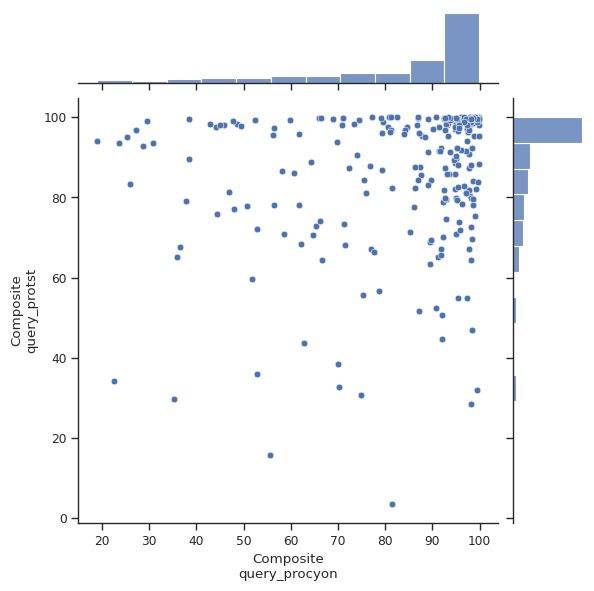

In [50]:
sns.jointplot(x="Composite\nquery_procyon", y="Composite\nquery_protst", data=check)

/tmp/ipykernel_69381/2256770444.py:9: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:cornflowerblue'` for the same effect.

  sns.stripplot(


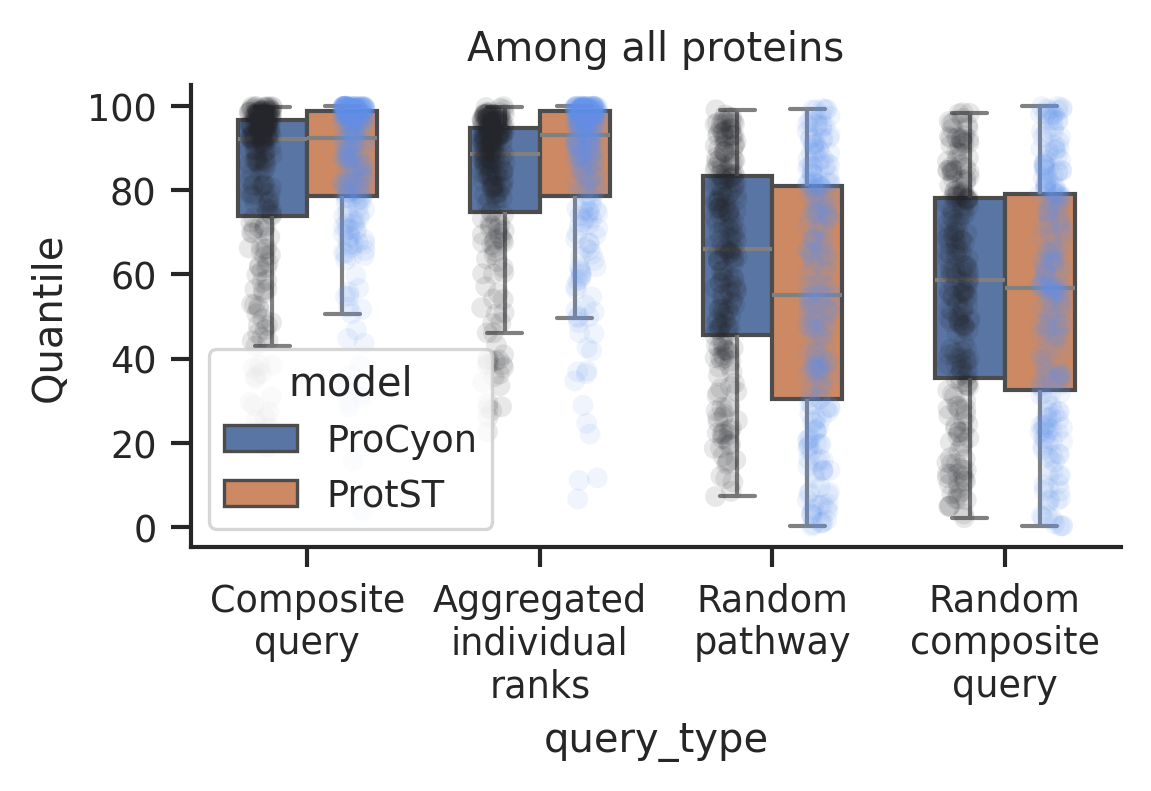

WilcoxonResult(statistic=16337.5, pvalue=0.012462643459268782)
WilcoxonResult(statistic=25680.0, pvalue=3.966727105121499e-29)
WilcoxonResult(statistic=23299.0, pvalue=3.5575200559097323e-19)


In [52]:
from scipy.stats import wilcoxon

plt.figure(figsize=(4, 2), dpi=300)
sns.set(context="paper", style="ticks", font_scale=1)
# sns.stripplot(
#     temp,
#     alpha=.1, color="cornflowerblue"
# )
sns.stripplot(
    x="query_type",
    y="score",
    hue="model",
    dodge=True,
    data=combined_results,
    alpha=.1,
    color="cornflowerblue",
    legend=False,
)
sns.boxplot(
    x="query_type",
    y="score",
    hue="model",
    data=combined_results,
    showfliers=False,
    width=0.6,
    #boxprops={"linestyle":"-", "linewidth":1, "facecolor":(0,0,0,0), "edgecolor":"gray"},
    capprops=dict(color="gray"),
    whiskerprops=dict(color="gray"),
    flierprops=dict(color="gray", markeredgecolor="gray"),
    medianprops=dict(color="gray"),
)
sns.despine()
plt.ylabel("Quantile")
plt.title("Among all proteins")
plt.show()

print(
    stats.wilcoxon(
        temp["Composite\nquery"].values,
        temp["Aggregated\nindividual\nranks"].values,
        alternative="greater",
    )
)
print(
    stats.wilcoxon(
        temp["Composite\nquery"].values,
        temp["Random\ncomposite\nquery"].values,
        alternative="greater",
    )
)
print(
    stats.wilcoxon(
        temp["Composite\nquery"].values,
        temp["Random\npathway"].values,
        alternative="greater",
    )
)

# Pleiotropy: Biological process + biological process

Select all pairs of processes that satisfy:
- Both are above level 2 (i.e. 3+)
- Neither is the other's ancestor
- They do not share any offspring GO terms
- They have >=3 but <=20 overlapping protein annotations


In [13]:
go_procs = go_proteins.query("text_type == 'Process'").index
go_procs = go_info.set_index("go_id").loc[go_procs].query("go_level >= 3")
print(go_procs.shape)

go_procs_proteins = go_proteins.loc[go_procs.index]

(3147, 11)


In [14]:
all_go_ancestors = torch.load(composition_path("all_go_ancestors.pkl"))
go_procs_ancestors = {go_id:all_go_ancestors[go_id] for go_id in go_procs.index}

all_go_offsprings = torch.load(composition_path("all_go_offsprings.pkl"))
go_procs_offsprings = {go_id:all_go_offsprings[go_id] for go_id in go_procs.index}

In [15]:
# get go pair offspring overlap info
temp = (
    pd.melt(pd.DataFrame.from_dict(go_procs_offsprings, orient="index").reset_index(), id_vars="index").
    dropna().drop(columns=["variable"]).sort_values("index").reset_index(drop=True).
    rename(columns={"index":"go_id", "value":"offspring"})
)
temp["value"] = 1
go_procs_offsprings_wide = pd.pivot_table(temp, values="value", index="go_id", columns="offspring").fillna(0)
go_procs_offsprings_overlap = pd.DataFrame(((go_procs_offsprings_wide.values @ go_procs_offsprings_wide.values.T) > 0).astype(int),
                                           columns=go_procs_offsprings_wide.index, index=go_procs_offsprings_wide.index)  # 1 = has overlapping offsprings, 0 = no overlap; 2840 * 2840

# add back GOs that are without offsprings
go_procs_offsprings_overlap = pd.concat([
    go_procs_offsprings_overlap,
    pd.DataFrame([[0] * go_procs_offsprings_overlap.shape[1]] * (go_procs_proteins.shape[0] - go_procs_offsprings_overlap.shape[0]),
                 columns=go_procs_offsprings_overlap.columns, index=go_procs_proteins.index[~go_procs_proteins.index.isin(go_procs_offsprings_overlap.index)])
], axis=0)
go_procs_offsprings_overlap = pd.concat([
    go_procs_offsprings_overlap,
    pd.DataFrame([[0] * (go_procs_proteins.shape[0] - go_procs_offsprings_overlap.shape[1])] * go_procs_offsprings_overlap.shape[0],
                 columns=go_procs_proteins.index[~go_procs_proteins.index.isin(go_procs_offsprings_overlap.columns)], index=go_procs_offsprings_overlap.index)
], axis=1)

go_procs_offsprings_overlap = go_procs_offsprings_overlap.sort_index()
go_procs_offsprings_overlap = go_procs_offsprings_overlap[sorted(go_procs_offsprings_overlap.columns)].copy()
go_procs_offsprings_overlap.values[np.diag_indices_from(go_procs_offsprings_overlap.values)] = 0
go_procs_offsprings_overlap

,GO:0000018,GO:0000027,GO:0000038,GO:0000041,GO:0000045,GO:0000070,GO:0000075,GO:0000077,GO:0000079,GO:0000082,...,GO:2001237,GO:2001238,GO:2001242,GO:2001243,GO:2001244,GO:2001251,GO:2001252,GO:2001257,GO:2001258,GO:2001259
GO:0000018,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0
GO:0000027,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GO:0000038,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GO:0000041,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GO:0000045,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GO:2001251,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GO:2001252,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GO:2001257,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
GO:2001258,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [16]:
# get go pair (mutual) ancestral info
temp = (
    pd.melt(pd.DataFrame.from_dict({k: {vv for vv in v if vv in go_procs_proteins.index.values} for k, v in go_procs_ancestors.items()}, orient="index").reset_index(), id_vars="index").
    dropna().drop(columns=["variable"]).sort_values("index").reset_index(drop=True).
    rename(columns={"index":"go_id", "value":"offspring"})
)
temp["value"] = 1
go_procs_ancestors_wide = pd.pivot_table(temp, values="value", index="go_id", columns="offspring").fillna(0).astype(int)  # 1 = has ancestor, 0 = no overlap, 3147 * 2312

# add back GOs that are not ancestral to any other GOs
go_procs_ancestors_wide = pd.concat([
    go_procs_ancestors_wide,
    pd.DataFrame([[0] * go_procs_ancestors_wide.shape[1]] * (go_procs_proteins.shape[0] - go_procs_ancestors_wide.shape[0]),
                 columns=go_procs_ancestors_wide.columns, index=go_procs_proteins.index[~go_procs_proteins.index.isin(go_procs_ancestors_wide.index)])
], axis=0)
go_procs_ancestors_wide = pd.concat([
    go_procs_ancestors_wide,
    pd.DataFrame([[0] * (go_procs_proteins.shape[0] - go_procs_ancestors_wide.shape[1])] * go_procs_ancestors_wide.shape[0],
                 columns=go_procs_proteins.index[~go_procs_proteins.index.isin(go_procs_ancestors_wide.columns)], index=go_procs_ancestors_wide.index)
], axis=1)

go_procs_ancestors_wide = go_procs_ancestors_wide.sort_index()
go_procs_ancestors_wide = go_procs_ancestors_wide[sorted(go_procs_ancestors_wide.columns)].copy()
go_procs_ancestors_wide.values[np.diag_indices_from(go_procs_ancestors_wide.values)] = 0
go_procs_ancestors_wide = ((go_procs_ancestors_wide + go_procs_ancestors_wide.T) > 0).astype(int)
go_procs_ancestors_wide

,GO:0000018,GO:0000027,GO:0000038,GO:0000041,GO:0000045,GO:0000070,GO:0000075,GO:0000077,GO:0000079,GO:0000082,...,GO:2001237,GO:2001238,GO:2001242,GO:2001243,GO:2001244,GO:2001251,GO:2001252,GO:2001257,GO:2001258,GO:2001259
GO:0000018,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GO:0000027,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GO:0000038,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GO:0000041,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GO:0000045,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GO:2001251,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GO:2001252,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GO:2001257,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
GO:2001258,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [17]:
go_procs_overlap = go_procs_proteins[["seq_id"]].explode("seq_id")
go_procs_overlap["value"] = 1
go_procs_overlap = pd.pivot_table(go_procs_overlap.reset_index(), values="value", index="text_id", columns="seq_id").fillna(0)
go_procs_overlap = pd.DataFrame(go_procs_overlap.values @ go_procs_overlap.values.T, columns=go_procs_overlap.index, index=go_procs_overlap.index)

# keep only upper tril
go_procs_overlap.values[np.tril_indices_from(go_procs_overlap.values, k=0)] = 0

# set those pairs with overlapping offspring terms to 0
go_procs_overlap.values[go_procs_offsprings_overlap.values.astype(bool)] = 0
print(np.where((go_procs_overlap >= 3) & (go_procs_overlap <= 20))[0].shape)

# set those pairs that are ancestors to one another to 0
go_procs_overlap.values[go_procs_ancestors_wide.values.astype(bool)] = 0
print(np.where((go_procs_overlap >= 3) & (go_procs_overlap <= 20))[0].shape)

all_valid_go_pairs = list(zip(*[go_procs_overlap.index[np.where((go_procs_overlap >= 3) & (go_procs_overlap <= 20))[0]].values.tolist(), go_procs_overlap.columns[np.where((go_procs_overlap >= 3) & (go_procs_overlap <= 20))[1]].values.tolist()]))

(250843,)
(249556,)


The cell below will take a while to run (several hours) and consume ~60GB of RAM due to the large number of data points considered. For this reason, we've made the cached data available within ProCyon-Instruct, but feel free to set `regenerate_data` to True if you'd like to rerun from scratch.

In [18]:
regenerate_data = False

if regenerate_data:
    temp = go_procs_proteins[["seq_id"]].explode("seq_id")
    temp["value"] = 1
    temp = pd.pivot_table(temp.reset_index(), values="value", index="text_id", columns="seq_id").fillna(0)
    temp_values = temp.values

    temp_go_to_ind = {go:ind for ind, go in enumerate(temp.index)}
    prots_onehot = []
    for go_1, go_2 in all_valid_go_pairs:
        prots_onehot.append((temp_values[[temp_go_to_ind[go_1], temp_go_to_ind[go_2]], :].sum(axis=0) == 2).astype(int).tolist())

    t = pd.DataFrame(np.array(prots_onehot), columns=temp.columns, index=all_valid_go_pairs)

    tt = pd.DataFrame(t.values @ temp.values.T, columns=temp.index, index=t.index)

    tt_values = tt.values
    go_pairs = tt.index.values
    gos = tt.columns.values

    valid_go_triplets = []
    for index_ind, col_ind in zip(
        np.random.choice(np.arange(tt.shape[0]), size=10000000, replace=True),
        np.random.choice(np.arange(tt.shape[1]), size=10000000, replace=True),
    ):
        go_pair = go_pairs[index_ind]
        add_go = gos[col_ind]
        if (go_pair[0] == add_go) or (go_pair[1] == add_go): continue
        if (tt_values[index_ind, col_ind] < 3) or (tt_values[index_ind, col_ind] > 20): continue

        go_1, go_2 = go_pair
        if add_go in go_ancestors[go_1].keys(): continue
        if add_go in go_ancestors[go_2].keys(): continue
        if go_1 in go_ancestors[add_go].keys(): continue
        if go_2 in go_ancestors[add_go].keys(): continue

        if len(go_procs_offsprings[go_1] & go_procs_offsprings[go_2]) > 0: continue
        if len(go_procs_offsprings[go_1] & go_procs_offsprings[add_go]) > 0: continue
        if len(go_procs_offsprings[go_2] & go_procs_offsprings[add_go]) > 0: continue

        valid_go_triplets.append((go_pair, add_go))

    valid_go_triplets = list(set(valid_go_triplets))
    print(len(valid_go_triplets))
    print(len(set([tuple(sorted(tup[0] + (tup[1],))) for tup in valid_go_triplets])))

    triplet_prots_onehot = pd.concat([(temp.loc[triplet, :].sum(0) == 3) for triplet
                                    in [tup[0] + (tup[1],) for tup in valid_go_triplets]], axis=1).astype(int)
    triplet_prots_onehot.columns = [tup[0] + (tup[1],) for tup in valid_go_triplets]
    display(triplet_prots_onehot)

    ttt = pd.DataFrame(triplet_prots_onehot.T.values @ temp.T.values, index=triplet_prots_onehot.columns, columns=temp.index)

    ttt_values = ttt.values
    go_triplets = ttt.index.values
    gos = ttt.columns.values

    valid_go_quadruplets = []
    for triplet_ind, add_ind in zip(
        np.random.choice(np.arange(ttt.shape[0]), size=10000000, replace=True),
        np.random.choice(np.arange(ttt.shape[1]), size=10000000, replace=True),
    ):
        go_triplet = go_triplets[triplet_ind]
        add_go = gos[add_ind]
        if (go_triplet[0] == add_go) or (go_triplet[1] == add_go) or (go_triplet[2] == add_go): continue
        if (ttt_values[triplet_ind, add_ind] < 3) or (ttt_values[triplet_ind, add_ind] > 20): continue

        go_1, go_2, go_3 = go_triplet
        if add_go in go_ancestors[go_1].keys(): continue
        if add_go in go_ancestors[go_2].keys(): continue
        if add_go in go_ancestors[go_3].keys(): continue
        if go_1 in go_ancestors[add_go].keys(): continue
        if go_2 in go_ancestors[add_go].keys(): continue
        if go_3 in go_ancestors[add_go].keys(): continue

        if len(go_procs_offsprings[go_1] & go_procs_offsprings[go_2]) > 0: continue
        if len(go_procs_offsprings[go_1] & go_procs_offsprings[go_3]) > 0: continue
        if len(go_procs_offsprings[go_1] & go_procs_offsprings[add_go]) > 0: continue
        if len(go_procs_offsprings[go_2] & go_procs_offsprings[go_3]) > 0: continue
        if len(go_procs_offsprings[go_2] & go_procs_offsprings[add_go]) > 0: continue
        if len(go_procs_offsprings[go_3] & go_procs_offsprings[add_go]) > 0: continue

        valid_go_quadruplets.append((go_triplet, add_go))

    valid_go_quanduplets = list(set(valid_go_quadruplets))
    print(len(valid_go_quanduplets))
    print(len(set([tuple(sorted(tup[0] + (tup[1],))) for tup in valid_go_quadruplets])))
    torch.save(valid_go_triplets, composition_path("valid_go_triplets.pkl"))
    torch.save(valid_go_quadruplets, composition_path("valid_go_quadruplets.pkl"))

else:
    valid_go_triplets = torch.load(composition_path("valid_go_triplets.pkl"))
    valid_go_quadruplets = torch.load(composition_path("valid_go_quadruplets.pkl"))

## Get predicted ranked list for each composition

The following cells will take a while to run (30 mins - 1 hour). Again, we've made the cached data available within ProCyon-Instruct, but feel free to set `regenerate_data` to True if you'd like to rerun from scratch

### Pairs

In [19]:
regenerate_data = False

batch_size = 5
test_sample_size = 1000
random.seed(42)
sampled_valid_go_pairs = random.sample(all_valid_go_pairs, k=test_sample_size)

if regenerate_data:
    # Pairs

    all_valid_go_pair_sims_ranks_geom = []
    task_def = "You will be shown text descriptions of two biological processes. Your job is to determine if a protein is involved in both processes described. Involvement is determined by whe ther or not there is evidence from an experiment directly supporting the annotation of the protein."

    start = time()
    for st in range(0, test_sample_size, batch_size):
        print(st)

        batch_valid_go_pairs = sampled_valid_go_pairs[st:st+batch_size]

        batched_input_descs = []
        for pathway_go_1, pathway_go_2 in batch_valid_go_pairs:
            input_desc_1 = go_procs.loc[pathway_go_1, 'go_def']
            input_desc_2 = go_procs.loc[pathway_go_2, 'go_def']

            batched_input_descs.append(input_desc_1 + "\n" + input_desc_2)
            batched_input_descs.append(input_desc_2 + "\n" + input_desc_1)

        # Composition query
        batched_input = create_batched_input_retrieval(
            input_descriptions = batched_input_descs,
            data_args=data_args,
            task_definitions = [task_def] * len(batched_input_descs),
            instruction_source_dataset = "go",
            instruction_source_relation = "process",
            aaseq_type = "protein",
            icl_example_number = 0,
        )

        with torch.no_grad():
            model_out = model(
                inputs = batched_input,
                retrieval=True,
                aaseq_type='protein',
            )

        sims = get_proteins_from_batched_embeddings(
            protein_embeds=all_protein_embeddings,
            query_embeddings=model_out["contrastive_out"]["positive"]["text"],
        ).float()
        sims_rank = stats.rankdata(sims, axis=-1)

        del model_out
        torch.cuda.empty_cache()

        for st in range(0, sims.shape[0], 2):
            sims_1_rank = sims_rank[st]
            sims_2_rank = sims_rank[st+1]
            sims_aggr_geom_rank = stats.gmean(np.stack([sims_1_rank, sims_2_rank]), axis=0)
            sims_ranks_aggr_geom_rank = stats.rankdata(sims_aggr_geom_rank)

            all_valid_go_pair_sims_ranks_geom.append(sims_ranks_aggr_geom_rank)

    end = time()
    print(end-start)

    all_valid_go_pair_sims_ranks_geom = np.stack(all_valid_go_pair_sims_ranks_geom)
    np.save(composition_path("all_valid_go_pair_sims_ranks_geom.npy"), all_valid_go_pair_sims_ranks_geom)
    torch.save(sampled_valid_go_pairs, composition_path("sampled_valid_go_pairs.pkl"))

else:
    all_valid_go_pair_sims_ranks_geom = np.load(composition_path("all_valid_go_pair_sims_ranks_geom.npy"))
    sampled_valid_go_pairs = torch.load(composition_path("sampled_valid_go_pairs.pkl"))

In [21]:
if regenerate_protst:
    protst_all_valid_go_pair_sims_ranks_geom = []
    task_def = "You will be shown text descriptions of two biological processes. Your job is to determine if a protein is involved in both processes described. Involvement is determined by whe ther or not there is evidence from an experiment directly supporting the annotation of the protein."

    for st in range(0, test_sample_size, batch_size):
        batch_valid_go_pairs = sampled_valid_go_pairs[st:st+batch_size]

        batched_input_descs = []
        for pathway_go_1, pathway_go_2 in batch_valid_go_pairs:
            input_desc_1 = go_procs.loc[pathway_go_1, 'go_def']
            input_desc_2 = go_procs.loc[pathway_go_2, 'go_def']

            batched_input_descs.append(input_desc_1 + "\n" + input_desc_2)
            batched_input_descs.append(input_desc_2 + "\n" + input_desc_1)

        text_embeds = protst_model._get_text_embedding(batched_input_descs)

        sims = get_proteins_from_batched_embeddings(
            protein_embeds=protst_protein_embeddings,
            query_embeddings=text_embeds,
        ).float()
        sims_rank = stats.rankdata(sims, axis=-1)


        for st in range(0, sims.shape[0], 2):
            sims_1_rank = sims_rank[st]
            sims_2_rank = sims_rank[st+1]
            sims_aggr_geom_rank = stats.gmean(np.stack([sims_1_rank, sims_2_rank]), axis=0)
            sims_ranks_aggr_geom_rank = stats.rankdata(sims_aggr_geom_rank)

            protst_all_valid_go_pair_sims_ranks_geom.append(sims_ranks_aggr_geom_rank)

    protst_all_valid_go_pair_sims_ranks_geom = np.stack(protst_all_valid_go_pair_sims_ranks_geom)
    np.save(composition_path("protst_all_valid_go_pair_sims_ranks_geom.npy"), protst_all_valid_go_pair_sims_ranks_geom)
else:
    protst_all_valid_go_pair_sims_ranks_geom = np.load(composition_path("all_valid_go_pair_sims_ranks_geom.npy"))

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
105
110
115
120
125
130
135
140
145
150
155
160
165
170
175
180
185
190
195
200
205
210
215
220
225
230
235
240
245
250
255
260
265
270
275
280
285
290
295
300
305
310
315
320
325
330
335
340
345
350
355
360
365
370
375
380
385
390
395
400
405
410
415
420
425
430
435
440
445
450
455
460
465
470
475
480
485
490
495
500
505
510
515
520
525
530
535
540
545
550
555
560
565
570
575
580
585
590
595
600
605
610
615
620
625
630
635
640
645
650
655
660
665
670
675
680
685
690
695
700
705
710
715
720
725
730
735
740
745
750
755
760
765
770
775
780
785
790
795
800
805
810
815
820
825
830
835
840
845
850
855
860
865
870
875
880
885
890
895
900
905
910
915
920
925
930
935
940
945
950
955
960
965
970
975
980
985
990
995


### Triplets

In [22]:
batch_size = 1
test_sample_size = 500
sampled_valid_go_triplets = list(set([tuple(sorted(tup[0] + (tup[1],))) for tup in valid_go_triplets]))[:test_sample_size]

if regenerate_data:
    # triplets
    all_valid_go_triplet_sims_ranks_geom = []
    task_def = "You will be shown text descriptions of three biological processes. Your job is to determine if a protein is involved in all processes described. Involvement is determined by whe ther or not there is evidence from an experiment directly supporting the annotation of the protein."

    start = time()
    for st in range(0, test_sample_size, batch_size):
        print(st)

        batch_valid_go_triplets = sampled_valid_go_triplets[st:st+batch_size]

        batched_input_descs = []
        for pathway_go_1, pathway_go_2, pathway_go_3 in batch_valid_go_triplets:
            input_desc_1 = go_procs.loc[pathway_go_1, 'go_def']
            input_desc_2 = go_procs.loc[pathway_go_2, 'go_def']
            input_desc_3 = go_procs.loc[pathway_go_3, 'go_def']

            batched_input_descs.append(input_desc_1 + "\n" + input_desc_2 + "\n" + input_desc_3)
            batched_input_descs.append(input_desc_1 + "\n" + input_desc_3 + "\n" + input_desc_2)
            batched_input_descs.append(input_desc_2 + "\n" + input_desc_1 + "\n" + input_desc_3)
            batched_input_descs.append(input_desc_2 + "\n" + input_desc_3 + "\n" + input_desc_1)
            batched_input_descs.append(input_desc_3 + "\n" + input_desc_1 + "\n" + input_desc_2)
            batched_input_descs.append(input_desc_3 + "\n" + input_desc_2 + "\n" + input_desc_1)

        # Composition query
        batched_input = create_batched_input_retrieval(
            input_descriptions = batched_input_descs,
            data_args=data_args,
            task_definitions = [task_def] * len(batched_input_descs),
            instruction_source_dataset = "go",
            instruction_source_relation = "process",
            aaseq_type = "protein",
            icl_example_number = 0,
        )

        with torch.no_grad():
            model_out = model(
                inputs = batched_input,
                retrieval=True,
                aaseq_type='protein',
            )

        sims = get_proteins_from_batched_embeddings(
            protein_embeds=all_protein_embeddings,
            query_embeddings=model_out["contrastive_out"]["positive"]["text"],
        )
        sims_rank = stats.rankdata(sims, axis=-1)

        del model_out
        torch.cuda.empty_cache()

        for st in range(0, sims.shape[0], 6):
            sims_aggr_geom_rank = stats.gmean(sims_rank[st:st+6], axis=0)
            sims_ranks_aggr_geom_rank = stats.rankdata(sims_aggr_geom_rank)

            all_valid_go_triplet_sims_ranks_geom.append(sims_ranks_aggr_geom_rank)

    end = time()
    print(end-start)

    all_valid_go_triplet_sims_ranks_geom = np.stack(all_valid_go_triplet_sims_ranks_geom)
    np.save(composition_path("all_valid_go_triplet_sims_ranks_geom.npy"), all_valid_go_triplet_sims_ranks_geom)
    torch.save(sampled_valid_go_triplets, composition_path("sampled_valid_go_triplets.pkl"))

else:
    all_valid_go_triplet_sims_ranks_geom = np.load(composition_path("all_valid_go_triplet_sims_ranks_geom.npy"))
    sampled_valid_go_triplets = torch.load(composition_path("sampled_valid_go_triplets.pkl"))

In [23]:
if regenerate_protst:
    # triplets
    protst_all_valid_go_triplet_sims_ranks_geom = []
    task_def = "You will be shown text descriptions of three biological processes. Your job is to determine if a protein is involved in all processes described. Involvement is determined by whe ther or not there is evidence from an experiment directly supporting the annotation of the protein."

    for st in range(0, test_sample_size, batch_size):
        batch_valid_go_triplets = sampled_valid_go_triplets[st:st+batch_size]

        batched_input_descs = []
        for pathway_go_1, pathway_go_2, pathway_go_3 in batch_valid_go_triplets:
            input_desc_1 = go_procs.loc[pathway_go_1, 'go_def']
            input_desc_2 = go_procs.loc[pathway_go_2, 'go_def']
            input_desc_3 = go_procs.loc[pathway_go_3, 'go_def']

            batched_input_descs.append(input_desc_1 + "\n" + input_desc_2 + "\n" + input_desc_3)
            batched_input_descs.append(input_desc_1 + "\n" + input_desc_3 + "\n" + input_desc_2)
            batched_input_descs.append(input_desc_2 + "\n" + input_desc_1 + "\n" + input_desc_3)
            batched_input_descs.append(input_desc_2 + "\n" + input_desc_3 + "\n" + input_desc_1)
            batched_input_descs.append(input_desc_3 + "\n" + input_desc_1 + "\n" + input_desc_2)
            batched_input_descs.append(input_desc_3 + "\n" + input_desc_2 + "\n" + input_desc_1)

        text_embeds = protst_model._get_text_embedding(batched_input_descs)

        sims = get_proteins_from_batched_embeddings(
            protein_embeds=protst_protein_embeddings,
            query_embeddings=text_embeds,
        ).float()
        sims_rank = stats.rankdata(sims, axis=-1)

        for st in range(0, sims.shape[0], 6):
            sims_aggr_geom_rank = stats.gmean(sims_rank[st:st+6], axis=0)
            sims_ranks_aggr_geom_rank = stats.rankdata(sims_aggr_geom_rank)

            protst_all_valid_go_triplet_sims_ranks_geom.append(sims_ranks_aggr_geom_rank)


    protst_all_valid_go_triplet_sims_ranks_geom = np.stack(protst_all_valid_go_triplet_sims_ranks_geom)
    np.save(composition_path("protst_all_valid_go_triplet_sims_ranks_geom.npy"), protst_all_valid_go_triplet_sims_ranks_geom)
else:
    protst_all_valid_go_triplet_sims_ranks_geom = np.load(composition_path("protst_all_valid_go_triplet_sims_ranks_geom.npy"))

### Quadruplets

In [24]:
batch_size = 1
test_sample_size = 200
sampled_valid_go_quadruplets = list(set([tuple(sorted(tup[0] + (tup[1],))) for tup in valid_go_quadruplets]))[:test_sample_size]

if regenerate_data:
    # quadruplets
    all_valid_go_quadruplet_sims_ranks_geom = []
    task_def = "You will be shown text descriptions of four biological processes. Your job is to determine if a protein is involved in all processes described. Involvement is determined by whe ther or not there is evidence from an experiment directly supporting the annotation of the protein."

    start = time()
    for st in range(0, test_sample_size, batch_size):
        print(st)

        batch_valid_go_quadruplets = sampled_valid_go_quadruplets[st:st+batch_size]

        batched_input_descs = []
        for pathway_go_1, pathway_go_2, pathway_go_3, pathway_go_4 in batch_valid_go_quadruplets:
            input_desc_1 = go_procs.loc[pathway_go_1, 'go_def']
            input_desc_2 = go_procs.loc[pathway_go_2, 'go_def']
            input_desc_3 = go_procs.loc[pathway_go_3, 'go_def']
            input_desc_4 = go_procs.loc[pathway_go_4, 'go_def']

            batched_input_descs.append(input_desc_1 + "\n" + input_desc_2 + "\n" + input_desc_3 + "\n" + input_desc_4)
            batched_input_descs.append(input_desc_1 + "\n" + input_desc_2 + "\n" + input_desc_4 + "\n" + input_desc_3)
            batched_input_descs.append(input_desc_1 + "\n" + input_desc_3 + "\n" + input_desc_2 + "\n" + input_desc_4)
            batched_input_descs.append(input_desc_1 + "\n" + input_desc_3 + "\n" + input_desc_4 + "\n" + input_desc_2)
            batched_input_descs.append(input_desc_1 + "\n" + input_desc_4 + "\n" + input_desc_2 + "\n" + input_desc_3)
            batched_input_descs.append(input_desc_1 + "\n" + input_desc_4 + "\n" + input_desc_3 + "\n" + input_desc_2)
            batched_input_descs.append(input_desc_2 + "\n" + input_desc_1 + "\n" + input_desc_3 + "\n" + input_desc_4)
            batched_input_descs.append(input_desc_2 + "\n" + input_desc_1 + "\n" + input_desc_4 + "\n" + input_desc_3)

            batched_input_descs.append(input_desc_2 + "\n" + input_desc_3 + "\n" + input_desc_1 + "\n" + input_desc_4)
            batched_input_descs.append(input_desc_2 + "\n" + input_desc_3 + "\n" + input_desc_4 + "\n" + input_desc_1)
            batched_input_descs.append(input_desc_2 + "\n" + input_desc_4 + "\n" + input_desc_1 + "\n" + input_desc_3)
            batched_input_descs.append(input_desc_2 + "\n" + input_desc_4 + "\n" + input_desc_3 + "\n" + input_desc_1)
            batched_input_descs.append(input_desc_3 + "\n" + input_desc_1 + "\n" + input_desc_2 + "\n" + input_desc_4)
            batched_input_descs.append(input_desc_3 + "\n" + input_desc_1 + "\n" + input_desc_4 + "\n" + input_desc_2)
            batched_input_descs.append(input_desc_3 + "\n" + input_desc_2 + "\n" + input_desc_1 + "\n" + input_desc_4)
            batched_input_descs.append(input_desc_3 + "\n" + input_desc_2 + "\n" + input_desc_4 + "\n" + input_desc_1)

            batched_input_descs.append(input_desc_3 + "\n" + input_desc_4 + "\n" + input_desc_1 + "\n" + input_desc_2)
            batched_input_descs.append(input_desc_3 + "\n" + input_desc_4 + "\n" + input_desc_2 + "\n" + input_desc_1)
            batched_input_descs.append(input_desc_4 + "\n" + input_desc_1 + "\n" + input_desc_2 + "\n" + input_desc_4)
            batched_input_descs.append(input_desc_4 + "\n" + input_desc_1 + "\n" + input_desc_4 + "\n" + input_desc_2)
            batched_input_descs.append(input_desc_4 + "\n" + input_desc_2 + "\n" + input_desc_1 + "\n" + input_desc_4)
            batched_input_descs.append(input_desc_4 + "\n" + input_desc_2 + "\n" + input_desc_4 + "\n" + input_desc_1)
            batched_input_descs.append(input_desc_4 + "\n" + input_desc_4 + "\n" + input_desc_1 + "\n" + input_desc_2)
            batched_input_descs.append(input_desc_4 + "\n" + input_desc_4 + "\n" + input_desc_2 + "\n" + input_desc_1)

        # Composition query
        simss = []
        for st in np.arange(0, 24, 8):
            batched_input = create_batched_input_retrieval(
                input_descriptions = batched_input_descs[st:st+8],
                data_args=data_args,
                task_definitions = [task_def] * 8,
                instruction_source_dataset = "go",
                instruction_source_relation = "process",
                aaseq_type = "protein",
                icl_example_number = 0,
            )

            with torch.no_grad():
                model_out = model(
                    inputs = batched_input,
                    retrieval=True,
                    aaseq_type='protein',
                )

            sims = get_proteins_from_batched_embeddings(
                protein_embeds=all_protein_embeddings,
                query_embeddings=model_out["contrastive_out"]["positive"]["text"],
            )
            simss.append(sims)

            del model_out
            torch.cuda.empty_cache()

        sims_rank = stats.rankdata(np.concatenate(simss, axis=0), axis=-1)

        assert sims_rank.shape[0] == 24
        sims_aggr_geom_rank = stats.gmean(sims_rank, axis=0)
        sims_ranks_aggr_geom_rank = stats.rankdata(sims_aggr_geom_rank)

        all_valid_go_quadruplet_sims_ranks_geom.append(sims_ranks_aggr_geom_rank)

    end = time()
    print(end-start)

    all_valid_go_quadruplet_sims_ranks_geom = np.stack(all_valid_go_quadruplet_sims_ranks_geom)
    np.save("all_valid_go_quadruplet_sims_ranks_geom.npy", all_valid_go_quadruplet_sims_ranks_geom)
    torch.save(sampled_valid_go_quadruplets, "sampled_valid_go_quadruplets.pkl")

else:
    all_valid_go_quadruplet_sims_ranks_geom = np.load(composition_path("all_valid_go_quadruplet_sims_ranks_geom.npy"))
    sampled_valid_go_quadruplets = torch.load(composition_path("sampled_valid_go_quadruplets.pkl"))

In [25]:
if regenerate_protst:
    # quadruplets
    protst_all_valid_go_quadruplet_sims_ranks_geom = []
    task_def = "You will be shown text descriptions of four biological processes. Your job is to determine if a protein is involved in all processes described. Involvement is determined by whe ther or not there is evidence from an experiment directly supporting the annotation of the protein."

    for st in range(0, test_sample_size, batch_size):
        batch_valid_go_quadruplets = sampled_valid_go_quadruplets[st:st+batch_size]

        batched_input_descs = []
        for pathway_go_1, pathway_go_2, pathway_go_3, pathway_go_4 in batch_valid_go_quadruplets:
            input_desc_1 = go_procs.loc[pathway_go_1, 'go_def']
            input_desc_2 = go_procs.loc[pathway_go_2, 'go_def']
            input_desc_3 = go_procs.loc[pathway_go_3, 'go_def']
            input_desc_4 = go_procs.loc[pathway_go_4, 'go_def']

            batched_input_descs.append(input_desc_1 + "\n" + input_desc_2 + "\n" + input_desc_3 + "\n" + input_desc_4)
            batched_input_descs.append(input_desc_1 + "\n" + input_desc_2 + "\n" + input_desc_4 + "\n" + input_desc_3)
            batched_input_descs.append(input_desc_1 + "\n" + input_desc_3 + "\n" + input_desc_2 + "\n" + input_desc_4)
            batched_input_descs.append(input_desc_1 + "\n" + input_desc_3 + "\n" + input_desc_4 + "\n" + input_desc_2)
            batched_input_descs.append(input_desc_1 + "\n" + input_desc_4 + "\n" + input_desc_2 + "\n" + input_desc_3)
            batched_input_descs.append(input_desc_1 + "\n" + input_desc_4 + "\n" + input_desc_3 + "\n" + input_desc_2)
            batched_input_descs.append(input_desc_2 + "\n" + input_desc_1 + "\n" + input_desc_3 + "\n" + input_desc_4)
            batched_input_descs.append(input_desc_2 + "\n" + input_desc_1 + "\n" + input_desc_4 + "\n" + input_desc_3)

            batched_input_descs.append(input_desc_2 + "\n" + input_desc_3 + "\n" + input_desc_1 + "\n" + input_desc_4)
            batched_input_descs.append(input_desc_2 + "\n" + input_desc_3 + "\n" + input_desc_4 + "\n" + input_desc_1)
            batched_input_descs.append(input_desc_2 + "\n" + input_desc_4 + "\n" + input_desc_1 + "\n" + input_desc_3)
            batched_input_descs.append(input_desc_2 + "\n" + input_desc_4 + "\n" + input_desc_3 + "\n" + input_desc_1)
            batched_input_descs.append(input_desc_3 + "\n" + input_desc_1 + "\n" + input_desc_2 + "\n" + input_desc_4)
            batched_input_descs.append(input_desc_3 + "\n" + input_desc_1 + "\n" + input_desc_4 + "\n" + input_desc_2)
            batched_input_descs.append(input_desc_3 + "\n" + input_desc_2 + "\n" + input_desc_1 + "\n" + input_desc_4)
            batched_input_descs.append(input_desc_3 + "\n" + input_desc_2 + "\n" + input_desc_4 + "\n" + input_desc_1)

            batched_input_descs.append(input_desc_3 + "\n" + input_desc_4 + "\n" + input_desc_1 + "\n" + input_desc_2)
            batched_input_descs.append(input_desc_3 + "\n" + input_desc_4 + "\n" + input_desc_2 + "\n" + input_desc_1)
            batched_input_descs.append(input_desc_4 + "\n" + input_desc_1 + "\n" + input_desc_2 + "\n" + input_desc_4)
            batched_input_descs.append(input_desc_4 + "\n" + input_desc_1 + "\n" + input_desc_4 + "\n" + input_desc_2)
            batched_input_descs.append(input_desc_4 + "\n" + input_desc_2 + "\n" + input_desc_1 + "\n" + input_desc_4)
            batched_input_descs.append(input_desc_4 + "\n" + input_desc_2 + "\n" + input_desc_4 + "\n" + input_desc_1)
            batched_input_descs.append(input_desc_4 + "\n" + input_desc_4 + "\n" + input_desc_1 + "\n" + input_desc_2)
            batched_input_descs.append(input_desc_4 + "\n" + input_desc_4 + "\n" + input_desc_2 + "\n" + input_desc_1)

        # Composition query
        simss = []
        for st in np.arange(0, 24, 8):
            text_embeds = protst_model._get_text_embedding(batched_input_descs[st:st+8])

            sims = get_proteins_from_batched_embeddings(
                protein_embeds=protst_protein_embeddings,
                query_embeddings=text_embeds,
            ).float()
            simss.append(sims)

        sims_rank = stats.rankdata(np.concatenate(simss, axis=0), axis=-1)

        assert sims_rank.shape[0] == 24
        sims_aggr_geom_rank = stats.gmean(sims_rank, axis=0)
        sims_ranks_aggr_geom_rank = stats.rankdata(sims_aggr_geom_rank)

        protst_all_valid_go_quadruplet_sims_ranks_geom.append(sims_ranks_aggr_geom_rank)

    protst_all_valid_go_quadruplet_sims_ranks_geom = np.stack(protst_all_valid_go_quadruplet_sims_ranks_geom)
    np.save("protst_all_valid_go_quadruplet_sims_ranks_geom.npy", protst_all_valid_go_quadruplet_sims_ranks_geom)
else:
    protst_all_valid_go_quadruplet_sims_ranks_geom = np.load(composition_path("protst_all_valid_go_quadruplet_sims_ranks_geom.npy"))

## Get predicted ranked list for each individual process

In [26]:
if regenerate_data:
    start = time()
    batch_size = 10
    all_individual_go_sims_ranks = []

    for st in range(0, len(go_procs), batch_size):
        print(st)
        batched_input_descs = []
        for pathway_go in go_procs.index.values[st:st+batch_size]:
            input_desc = go_procs.loc[pathway_go, 'go_def']
            batched_input_descs.append(input_desc)

        # Batched individual queries
        batched_input = create_batched_input_retrieval(
            input_descriptions = batched_input_descs,
            data_args=data_args,
            task_definitions = None,
            instruction_source_dataset = "go",
            instruction_source_relation = "process",
            aaseq_type = "protein",
            icl_example_number = 0,
        )

        with torch.no_grad():
            model_out = model(
                inputs = batched_input,
                retrieval=True,
                aaseq_type='protein',
            )

        sims = get_proteins_from_batched_embeddings(
            protein_embeds=all_protein_embeddings,
            query_embeddings=model_out["contrastive_out"]["positive"]["text"],
        )

        del model_out
        torch.cuda.empty_cache()

        sims_rank = stats.rankdata(sims, axis=-1)
        all_individual_go_sims_ranks.append(sims_rank)

    end = time()
    print(end-start)

    all_individual_go_sims_ranks = np.vstack(all_individual_go_sims_ranks)
    np.save(composition_path("all_individual_go_sims_ranks.npy"), all_individual_go_sims_ranks)

else:
    all_individual_go_sims_ranks = np.load(composition_path("all_individual_go_sims_ranks.npy"))

In [27]:
if regenerate_protst:
    batch_size = 10
    protst_all_individual_go_sims_ranks = []

    for st in range(0, len(go_procs), batch_size):
        batched_input_descs = []
        for pathway_go in go_procs.index.values[st:st+batch_size]:
            input_desc = go_procs.loc[pathway_go, 'go_def']
            batched_input_descs.append(input_desc)

        text_embeds = protst_model._get_text_embedding(batched_input_descs)

        sims = get_proteins_from_batched_embeddings(
            protein_embeds=protst_protein_embeddings,
            query_embeddings=text_embeds,
        ).float()


        sims_rank = stats.rankdata(sims, axis=-1)
        protst_all_individual_go_sims_ranks.append(sims_rank)

    protst_all_individual_go_sims_ranks = np.vstack(protst_all_individual_go_sims_ranks)
    np.save(composition_path("protst_all_individual_go_sims_ranks.npy"), protst_all_individual_go_sims_ranks)

else:
    protst_all_individual_go_sims_ranks = np.load(composition_path("protst_all_individual_go_sims_ranks.npy"))

## Get quantiles and plot

In [28]:
go_id_to_ind = go_procs.reset_index().drop(columns=["index"]).reset_index().set_index("text_id")["index"].to_dict()
uniprot_id_to_ind = protein_info[["protein_id", "index"]].set_index("protein_id")["index"]
num_proteins = uniprot_id_to_ind.shape[0]

In [29]:
quantiles_pair_composition_geom_rank_among_all = []
quantiles_pair_individual_geom_rank_among_all = []
quantiles_pair_random_composition_geom_rank_among_all = []
quantiles_triplet_composition_geom_rank_among_all = []
quantiles_triplet_individual_geom_rank_among_all = []
quantiles_triplet_random_composition_geom_rank_among_all = []
quantiles_quadruplet_composition_geom_rank_among_all = []
quantiles_quadruplet_individual_geom_rank_among_all = []
quantiles_quadruplet_random_composition_geom_rank_among_all = []
quantiles_random_pathway_rank_among_all = []


for i, (pathway_go_1, pathway_go_2) in enumerate(sampled_valid_go_pairs):
    pathway_1_prots = go_procs_proteins.loc[pathway_go_1, "seq_id"]
    pathway_2_prots = go_procs_proteins.loc[pathway_go_2, "seq_id"]

    go_ind_1 = go_id_to_ind[pathway_go_1]
    go_ind_2 = go_id_to_ind[pathway_go_2]
    individual_geom_rank_among_all = stats.rankdata(stats.gmean(all_individual_go_sims_ranks[[go_ind_1, go_ind_2], :], axis=0))

    pleiotropic_proteins = list(pathway_1_prots & pathway_2_prots)
    pleiotropic_proteins_inds = uniprot_id_to_ind[pleiotropic_proteins].values

    quantiles_pair_composition_geom_rank_among_all.append(
        all_valid_go_pair_sims_ranks_geom[i, pleiotropic_proteins_inds] / num_proteins
    )
    quantiles_pair_individual_geom_rank_among_all.append(
        individual_geom_rank_among_all[pleiotropic_proteins_inds] / num_proteins
    )
    quantiles_pair_random_composition_geom_rank_among_all.append(
        all_valid_go_pair_sims_ranks_geom[random.randint(0, all_valid_go_pair_sims_ranks_geom.shape[0]-1), pleiotropic_proteins_inds] / num_proteins
    )

    quantiles_random_pathway_rank_among_all.append(
        all_individual_go_sims_ranks[random.randint(0, all_individual_go_sims_ranks.shape[0]-1), pleiotropic_proteins_inds] / num_proteins
    )


for i, (pathway_go_1, pathway_go_2, pathway_go_3) in enumerate(sampled_valid_go_triplets):
    pathway_1_prots = go_procs_proteins.loc[pathway_go_1, "seq_id"]
    pathway_2_prots = go_procs_proteins.loc[pathway_go_2, "seq_id"]
    pathway_3_prots = go_procs_proteins.loc[pathway_go_3, "seq_id"]

    go_ind_1 = go_id_to_ind[pathway_go_1]
    go_ind_2 = go_id_to_ind[pathway_go_2]
    go_ind_3 = go_id_to_ind[pathway_go_3]
    individual_geom_rank_among_all = stats.rankdata(stats.gmean(all_individual_go_sims_ranks[[go_ind_1, go_ind_2, go_ind_3], :], axis=0))

    pleiotropic_proteins = list(pathway_1_prots & pathway_2_prots & pathway_3_prots)
    pleiotropic_proteins_inds = uniprot_id_to_ind[pleiotropic_proteins].values

    quantiles_triplet_composition_geom_rank_among_all.append(
        all_valid_go_triplet_sims_ranks_geom[i, pleiotropic_proteins_inds] / num_proteins
    )
    quantiles_triplet_individual_geom_rank_among_all.append(
        individual_geom_rank_among_all[pleiotropic_proteins_inds] / num_proteins
    )
    quantiles_triplet_random_composition_geom_rank_among_all.append(
        all_valid_go_triplet_sims_ranks_geom[random.randint(0, all_valid_go_triplet_sims_ranks_geom.shape[0]-1), pleiotropic_proteins_inds] / num_proteins
    )


for i, (pathway_go_1, pathway_go_2, pathway_go_3, pathway_go_4) in enumerate(sampled_valid_go_quadruplets):
    pathway_1_prots = go_procs_proteins.loc[pathway_go_1, "seq_id"]
    pathway_2_prots = go_procs_proteins.loc[pathway_go_2, "seq_id"]
    pathway_3_prots = go_procs_proteins.loc[pathway_go_3, "seq_id"]
    pathway_4_prots = go_procs_proteins.loc[pathway_go_4, "seq_id"]

    go_ind_1 = go_id_to_ind[pathway_go_1]
    go_ind_2 = go_id_to_ind[pathway_go_2]
    go_ind_3 = go_id_to_ind[pathway_go_3]
    go_ind_4 = go_id_to_ind[pathway_go_4]
    individual_geom_rank_among_all = stats.rankdata(stats.gmean(all_individual_go_sims_ranks[[go_ind_1, go_ind_2, go_ind_3, go_ind_4], :], axis=0))

    pleiotropic_proteins = list(pathway_1_prots & pathway_2_prots & pathway_3_prots & pathway_4_prots)
    pleiotropic_proteins_inds = uniprot_id_to_ind[pleiotropic_proteins].values

    quantiles_quadruplet_composition_geom_rank_among_all.append(
        all_valid_go_quadruplet_sims_ranks_geom[i, pleiotropic_proteins_inds] / num_proteins
    )
    quantiles_quadruplet_individual_geom_rank_among_all.append(
        individual_geom_rank_among_all[pleiotropic_proteins_inds] / num_proteins
    )
    quantiles_quadruplet_random_composition_geom_rank_among_all.append(
        all_valid_go_quadruplet_sims_ranks_geom[random.randint(0, all_valid_go_quadruplet_sims_ranks_geom.shape[0]-1), pleiotropic_proteins_inds] / num_proteins
    )

In [31]:
procyon_data = pd.DataFrame({
    "Rank type": ["Composite\nquery"] * np.concatenate(quantiles_pair_composition_geom_rank_among_all).shape[0] + \
    ["Aggregated\nindividual\nranks"] * np.concatenate(quantiles_pair_individual_geom_rank_among_all).shape[0] + \
    ["Random\ncomposite\nquery"] * np.concatenate(quantiles_pair_random_composition_geom_rank_among_all).shape[0] + \

    ["Composite\nquery"] * np.concatenate(quantiles_triplet_composition_geom_rank_among_all).shape[0] + \
    ["Aggregated\nindividual\nranks"] * np.concatenate(quantiles_triplet_individual_geom_rank_among_all).shape[0] + \
    ["Random\ncomposite\nquery"] * np.concatenate(quantiles_triplet_random_composition_geom_rank_among_all).shape[0] + \

    ["Composite\nquery"] * np.concatenate(quantiles_quadruplet_composition_geom_rank_among_all).shape[0] + \
    ["Aggregated\nindividual\nranks"] * np.concatenate(quantiles_quadruplet_individual_geom_rank_among_all).shape[0] + \
    ["Random\ncomposite\nquery"] * np.concatenate(quantiles_quadruplet_random_composition_geom_rank_among_all).shape[0] + \

    ["Random\npathway"] * np.concatenate(quantiles_random_pathway_rank_among_all).shape[0],


    "Quantiles": np.concatenate(quantiles_pair_composition_geom_rank_among_all).tolist() + \
    np.concatenate(quantiles_pair_individual_geom_rank_among_all).tolist() + \
    np.concatenate(quantiles_pair_random_composition_geom_rank_among_all).tolist() + \

    np.concatenate(quantiles_triplet_composition_geom_rank_among_all).tolist() + \
    np.concatenate(quantiles_triplet_individual_geom_rank_among_all).tolist() + \
    np.concatenate(quantiles_triplet_random_composition_geom_rank_among_all).tolist() + \

    np.concatenate(quantiles_quadruplet_composition_geom_rank_among_all).tolist() + \
    np.concatenate(quantiles_quadruplet_individual_geom_rank_among_all).tolist() + \
    np.concatenate(quantiles_quadruplet_random_composition_geom_rank_among_all).tolist() + \

    np.concatenate(quantiles_random_pathway_rank_among_all).tolist(),


    "Number of processes": ["Pair"] * (
        np.concatenate(quantiles_pair_composition_geom_rank_among_all).shape[0] + \
        np.concatenate(quantiles_pair_individual_geom_rank_among_all).shape[0] + \
        np.concatenate(quantiles_pair_random_composition_geom_rank_among_all).shape[0]
    ) + \
    ["Triplet"] * (
        np.concatenate(quantiles_triplet_composition_geom_rank_among_all).shape[0] + \
        np.concatenate(quantiles_triplet_individual_geom_rank_among_all).shape[0] + \
        np.concatenate(quantiles_triplet_random_composition_geom_rank_among_all).shape[0]
    ) + \
    ["Quadruplet"] * (
        np.concatenate(quantiles_quadruplet_composition_geom_rank_among_all).shape[0] + \
        np.concatenate(quantiles_quadruplet_individual_geom_rank_among_all).shape[0] + \
        np.concatenate(quantiles_quadruplet_random_composition_geom_rank_among_all).shape[0]
    ) + \
    ["Single"] * np.concatenate(quantiles_random_pathway_rank_among_all).shape[0]
})

In [32]:
quantiles_pair_composition_geom_rank_among_all = []
quantiles_pair_individual_geom_rank_among_all = []
quantiles_pair_random_composition_geom_rank_among_all = []
quantiles_triplet_composition_geom_rank_among_all = []
quantiles_triplet_individual_geom_rank_among_all = []
quantiles_triplet_random_composition_geom_rank_among_all = []
quantiles_quadruplet_composition_geom_rank_among_all = []
quantiles_quadruplet_individual_geom_rank_among_all = []
quantiles_quadruplet_random_composition_geom_rank_among_all = []
quantiles_random_pathway_rank_among_all = []


for i, (pathway_go_1, pathway_go_2) in enumerate(sampled_valid_go_pairs):
    pathway_1_prots = go_procs_proteins.loc[pathway_go_1, "seq_id"]
    pathway_2_prots = go_procs_proteins.loc[pathway_go_2, "seq_id"]

    go_ind_1 = go_id_to_ind[pathway_go_1]
    go_ind_2 = go_id_to_ind[pathway_go_2]
    individual_geom_rank_among_all = stats.rankdata(stats.gmean(protst_all_individual_go_sims_ranks[[go_ind_1, go_ind_2], :], axis=0))

    pleiotropic_proteins = list(pathway_1_prots & pathway_2_prots)
    pleiotropic_proteins_inds = uniprot_id_to_ind[pleiotropic_proteins].values

    quantiles_pair_composition_geom_rank_among_all.append(
        protst_all_valid_go_pair_sims_ranks_geom[i, pleiotropic_proteins_inds] / num_proteins
    )
    quantiles_pair_individual_geom_rank_among_all.append(
        individual_geom_rank_among_all[pleiotropic_proteins_inds] / num_proteins
    )
    quantiles_pair_random_composition_geom_rank_among_all.append(
        protst_all_valid_go_pair_sims_ranks_geom[random.randint(0, protst_all_valid_go_pair_sims_ranks_geom.shape[0]-1), pleiotropic_proteins_inds] / num_proteins
    )

    quantiles_random_pathway_rank_among_all.append(
        protst_all_individual_go_sims_ranks[random.randint(0, protst_all_individual_go_sims_ranks.shape[0]-1), pleiotropic_proteins_inds] / num_proteins
    )


for i, (pathway_go_1, pathway_go_2, pathway_go_3) in enumerate(sampled_valid_go_triplets):
    pathway_1_prots = go_procs_proteins.loc[pathway_go_1, "seq_id"]
    pathway_2_prots = go_procs_proteins.loc[pathway_go_2, "seq_id"]
    pathway_3_prots = go_procs_proteins.loc[pathway_go_3, "seq_id"]

    go_ind_1 = go_id_to_ind[pathway_go_1]
    go_ind_2 = go_id_to_ind[pathway_go_2]
    go_ind_3 = go_id_to_ind[pathway_go_3]
    individual_geom_rank_among_all = stats.rankdata(stats.gmean(protst_all_individual_go_sims_ranks[[go_ind_1, go_ind_2, go_ind_3], :], axis=0))

    pleiotropic_proteins = list(pathway_1_prots & pathway_2_prots & pathway_3_prots)
    pleiotropic_proteins_inds = uniprot_id_to_ind[pleiotropic_proteins].values

    quantiles_triplet_composition_geom_rank_among_all.append(
        protst_all_valid_go_triplet_sims_ranks_geom[i, pleiotropic_proteins_inds] / num_proteins
    )
    quantiles_triplet_individual_geom_rank_among_all.append(
        individual_geom_rank_among_all[pleiotropic_proteins_inds] / num_proteins
    )
    quantiles_triplet_random_composition_geom_rank_among_all.append(
        protst_all_valid_go_triplet_sims_ranks_geom[random.randint(0, protst_all_valid_go_triplet_sims_ranks_geom.shape[0]-1), pleiotropic_proteins_inds] / num_proteins
    )


for i, (pathway_go_1, pathway_go_2, pathway_go_3, pathway_go_4) in enumerate(sampled_valid_go_quadruplets):
    pathway_1_prots = go_procs_proteins.loc[pathway_go_1, "seq_id"]
    pathway_2_prots = go_procs_proteins.loc[pathway_go_2, "seq_id"]
    pathway_3_prots = go_procs_proteins.loc[pathway_go_3, "seq_id"]
    pathway_4_prots = go_procs_proteins.loc[pathway_go_4, "seq_id"]

    go_ind_1 = go_id_to_ind[pathway_go_1]
    go_ind_2 = go_id_to_ind[pathway_go_2]
    go_ind_3 = go_id_to_ind[pathway_go_3]
    go_ind_4 = go_id_to_ind[pathway_go_4]
    individual_geom_rank_among_all = stats.rankdata(stats.gmean(protst_all_individual_go_sims_ranks[[go_ind_1, go_ind_2, go_ind_3, go_ind_4], :], axis=0))

    pleiotropic_proteins = list(pathway_1_prots & pathway_2_prots & pathway_3_prots & pathway_4_prots)
    pleiotropic_proteins_inds = uniprot_id_to_ind[pleiotropic_proteins].values

    quantiles_quadruplet_composition_geom_rank_among_all.append(
        protst_all_valid_go_quadruplet_sims_ranks_geom[i, pleiotropic_proteins_inds] / num_proteins
    )
    quantiles_quadruplet_individual_geom_rank_among_all.append(
        individual_geom_rank_among_all[pleiotropic_proteins_inds] / num_proteins
    )
    quantiles_quadruplet_random_composition_geom_rank_among_all.append(
        protst_all_valid_go_quadruplet_sims_ranks_geom[random.randint(0, protst_all_valid_go_quadruplet_sims_ranks_geom.shape[0]-1), pleiotropic_proteins_inds] / num_proteins
    )

In [33]:
protst_data = pd.DataFrame({
    "Rank type": ["Composite\nquery"] * np.concatenate(quantiles_pair_composition_geom_rank_among_all).shape[0] + \
    ["Aggregated\nindividual\nranks"] * np.concatenate(quantiles_pair_individual_geom_rank_among_all).shape[0] + \
    ["Random\ncomposite\nquery"] * np.concatenate(quantiles_pair_random_composition_geom_rank_among_all).shape[0] + \

    ["Composite\nquery"] * np.concatenate(quantiles_triplet_composition_geom_rank_among_all).shape[0] + \
    ["Aggregated\nindividual\nranks"] * np.concatenate(quantiles_triplet_individual_geom_rank_among_all).shape[0] + \
    ["Random\ncomposite\nquery"] * np.concatenate(quantiles_triplet_random_composition_geom_rank_among_all).shape[0] + \

    ["Composite\nquery"] * np.concatenate(quantiles_quadruplet_composition_geom_rank_among_all).shape[0] + \
    ["Aggregated\nindividual\nranks"] * np.concatenate(quantiles_quadruplet_individual_geom_rank_among_all).shape[0] + \
    ["Random\ncomposite\nquery"] * np.concatenate(quantiles_quadruplet_random_composition_geom_rank_among_all).shape[0] + \

    ["Random\npathway"] * np.concatenate(quantiles_random_pathway_rank_among_all).shape[0],


    "Quantiles": np.concatenate(quantiles_pair_composition_geom_rank_among_all).tolist() + \
    np.concatenate(quantiles_pair_individual_geom_rank_among_all).tolist() + \
    np.concatenate(quantiles_pair_random_composition_geom_rank_among_all).tolist() + \

    np.concatenate(quantiles_triplet_composition_geom_rank_among_all).tolist() + \
    np.concatenate(quantiles_triplet_individual_geom_rank_among_all).tolist() + \
    np.concatenate(quantiles_triplet_random_composition_geom_rank_among_all).tolist() + \

    np.concatenate(quantiles_quadruplet_composition_geom_rank_among_all).tolist() + \
    np.concatenate(quantiles_quadruplet_individual_geom_rank_among_all).tolist() + \
    np.concatenate(quantiles_quadruplet_random_composition_geom_rank_among_all).tolist() + \

    np.concatenate(quantiles_random_pathway_rank_among_all).tolist(),


    "Number of processes": ["Pair"] * (
        np.concatenate(quantiles_pair_composition_geom_rank_among_all).shape[0] + \
        np.concatenate(quantiles_pair_individual_geom_rank_among_all).shape[0] + \
        np.concatenate(quantiles_pair_random_composition_geom_rank_among_all).shape[0]
    ) + \
    ["Triplet"] * (
        np.concatenate(quantiles_triplet_composition_geom_rank_among_all).shape[0] + \
        np.concatenate(quantiles_triplet_individual_geom_rank_among_all).shape[0] + \
        np.concatenate(quantiles_triplet_random_composition_geom_rank_among_all).shape[0]
    ) + \
    ["Quadruplet"] * (
        np.concatenate(quantiles_quadruplet_composition_geom_rank_among_all).shape[0] + \
        np.concatenate(quantiles_quadruplet_individual_geom_rank_among_all).shape[0] + \
        np.concatenate(quantiles_quadruplet_random_composition_geom_rank_among_all).shape[0]
    ) + \
    ["Single"] * np.concatenate(quantiles_random_pathway_rank_among_all).shape[0]
})

In [34]:
protst_data.head()

,Rank type,Quantiles,Number of processes
0,Composite\nquery,0.123088,Pair
1,Composite\nquery,0.574777,Pair
2,Composite\nquery,0.613789,Pair
3,Composite\nquery,0.989325,Pair
4,Composite\nquery,0.977936,Pair


In [35]:
procyon_data.head()

,Rank type,Quantiles,Number of processes
0,Composite\nquery,0.897078,Pair
1,Composite\nquery,0.557472,Pair
2,Composite\nquery,0.821861,Pair
3,Composite\nquery,0.890558,Pair
4,Composite\nquery,0.715005,Pair


In [36]:
plot_data = procyon_data

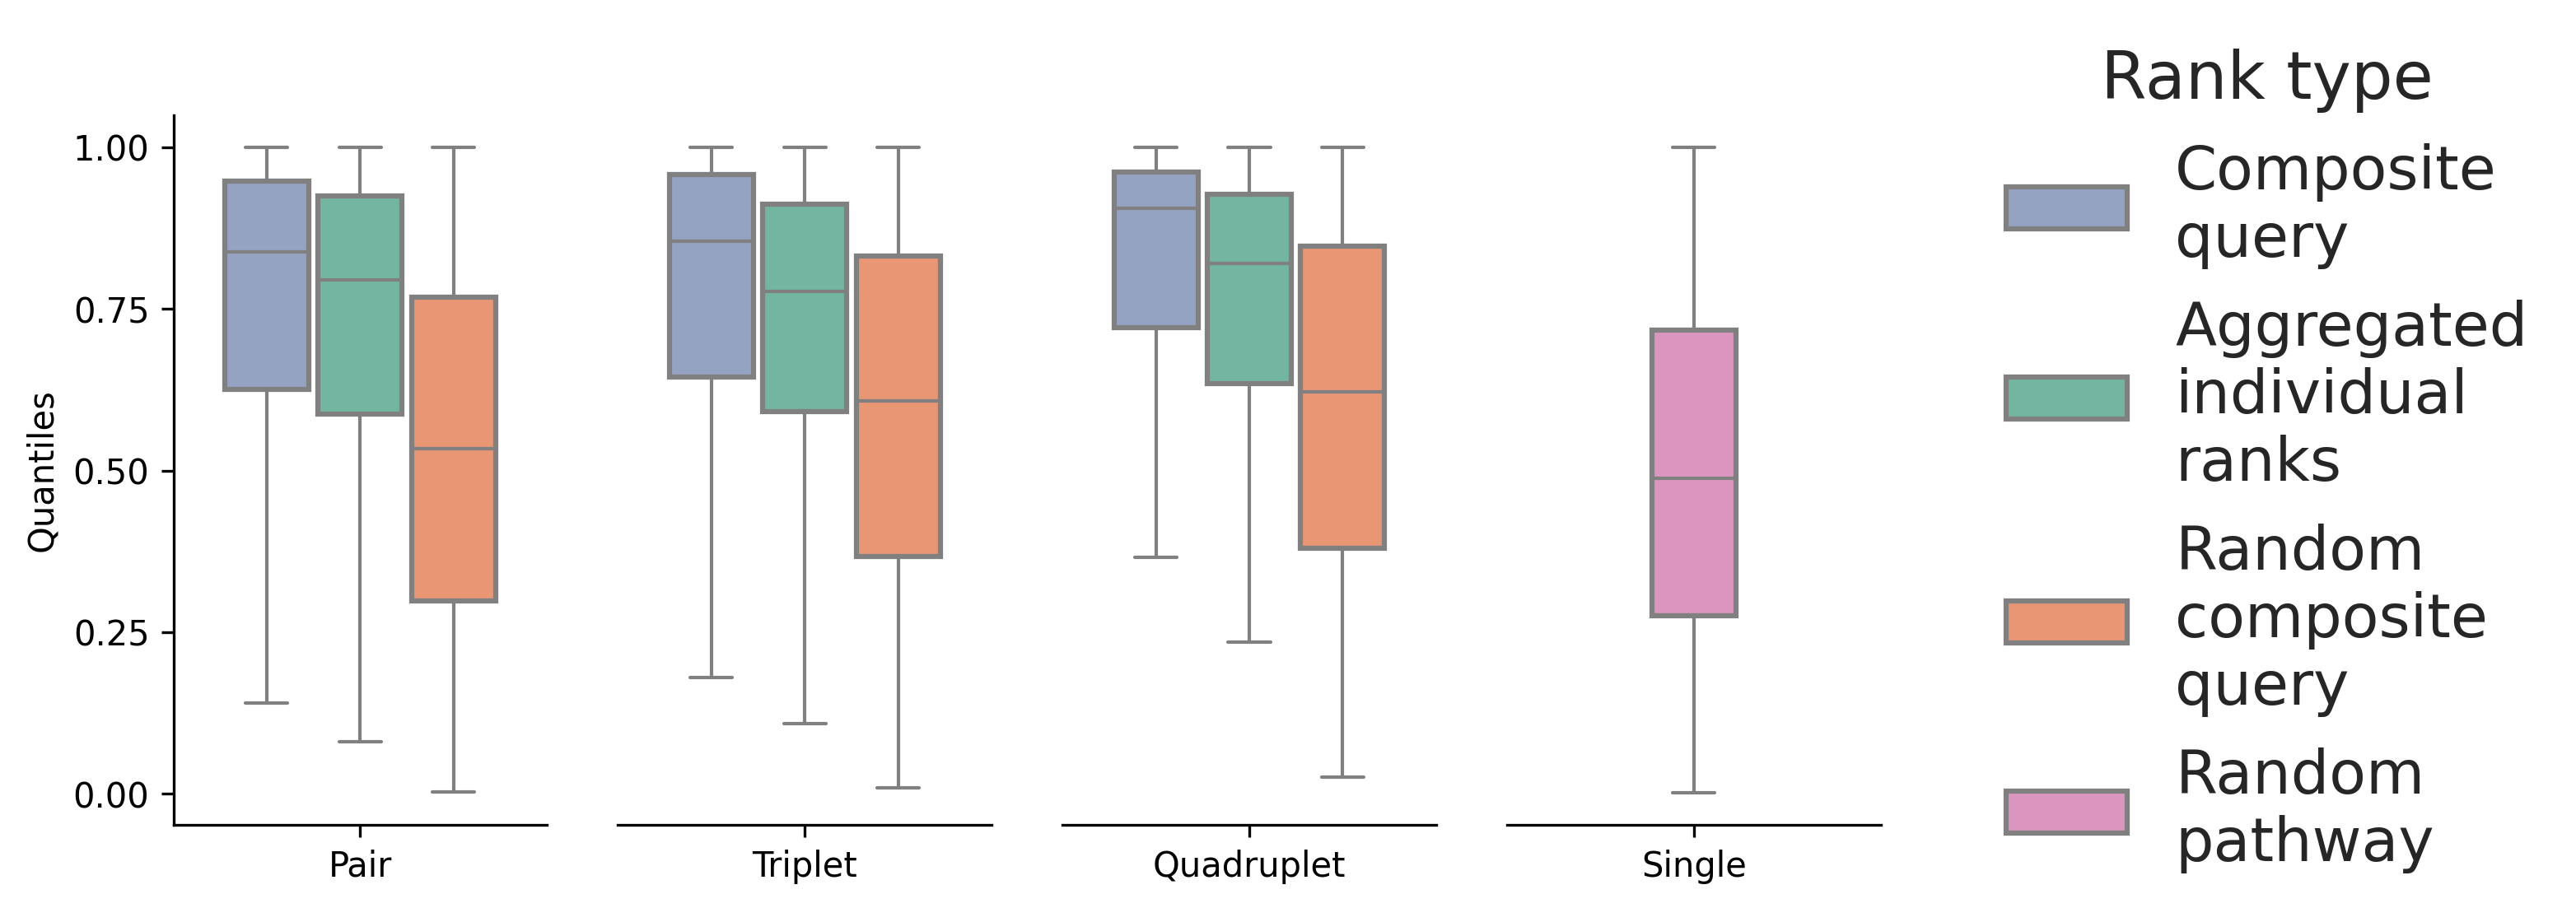

WilcoxonResult(statistic=9237014.5, pvalue=7.300248655903989e-49)
WilcoxonResult(statistic=12509608.5, pvalue=0.0)
MannwhitneyuResult(statistic=23387693.5, pvalue=0.0)
WilcoxonResult(statistic=492871.5, pvalue=3.45404317919578e-42)
WilcoxonResult(statistic=322036.5, pvalue=1.4399625883660536e-101)
MannwhitneyuResult(statistic=7730864.5, pvalue=6.738264299285646e-306)
WilcoxonResult(statistic=63080.0, pvalue=1.70029829993611e-21)
WilcoxonResult(statistic=39640.0, pvalue=3.2274012311759914e-46)
MannwhitneyuResult(statistic=3028830.5, pvalue=1.70288027860516e-173)


In [37]:
# Custom color palette as a dictionary
colors = ['#8da0cb', '#66c2a5', '#fc8d62', '#e78ac3']
hue_names = plot_data["Rank type"].unique()
palette = dict(zip(hue_names, colors))

# Determine the unique x values and corresponding unique hues
unique_xs = plot_data["Number of processes"].unique()
hue_dict = {x: plot_data[plot_data["Number of processes"] == x]["Rank type"].unique() for x in unique_xs}

# Create subplots
fig, axes = plt.subplots(1, len(unique_xs), figsize=(8, 4), sharey=True, dpi=300)
sns.set(context="paper", font_scale=2, style="white")

# Loop through each unique x and plot individually
handles_list = []
labels_list = []
for i, x in enumerate(unique_xs):
    ax = axes[i]

    sns_plot = sns.boxplot(
        data=plot_data.query("`Number of processes` == @x"),
        x="Number of processes",
        y="Quantiles",
        hue="Rank type",
        hue_order=hue_dict[x],
        width=0.25 if i == 3 else 0.75,
        dodge=True,
        showfliers=False,
        palette=palette,
        ax=ax,
        gap=0.1,
        boxprops={"edgecolor": 'gray', "linewidth": 1.5, "linestyle": '-'},
        whiskerprops={'color': 'gray', 'linestyle': '-'},
        capprops={'color': 'gray', 'linestyle': '-'},
        medianprops={'color': 'gray', 'linestyle': '-'}
    )

    # Remove upper and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Remove left border for the last three subplots
    if i >= len(unique_xs) - 3:
        ax.spines['left'].set_visible(False)
        ax.tick_params(left=False)


    # Remove legend for individual plots
    ax.get_legend().remove()
    ax.set_xlabel("")

    # Collect handles for global legend
    if sns_plot.get_legend_handles_labels()[0]:
        handles, labels = sns_plot.get_legend_handles_labels()
        for h, l in zip(handles, labels):
            if l not in labels_list:
                handles_list.append(h)
                labels_list.append(l)

# Create a unified legend
fig.legend(handles_list, labels_list, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title="Rank type")

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust the top to make space for the legend
plt.show()

print(
    stats.wilcoxon(
        plot_data.query("`Rank type` == 'Composite\\nquery' and `Number of processes` == 'Pair'")["Quantiles"].values,
        plot_data.query("`Rank type` == 'Aggregated\\nindividual\\nranks' and `Number of processes` == 'Pair'")["Quantiles"].values,
        alternative="greater",
    )
)
print(
    stats.wilcoxon(
        plot_data.query("`Rank type` == 'Composite\\nquery' and `Number of processes` == 'Pair'")["Quantiles"].values,
        plot_data.query("`Rank type` == 'Random\\ncomposite\\nquery' and `Number of processes` == 'Pair'")["Quantiles"].values,
        alternative="greater",
    )
)
print(
    stats.mannwhitneyu(
        plot_data.query("`Rank type` == 'Composite\\nquery' and `Number of processes` == 'Pair'")["Quantiles"].values,
        plot_data.query("`Rank type` == 'Random\\npathway'")["Quantiles"].values,
        alternative="greater",
    )
)

print(
    stats.wilcoxon(
        plot_data.query("`Rank type` == 'Composite\\nquery' and `Number of processes` == 'Triplet'")["Quantiles"].values,
        plot_data.query("`Rank type` == 'Aggregated\\nindividual\\nranks' and `Number of processes` == 'Triplet'")["Quantiles"].values,
    )
)
print(
    stats.wilcoxon(
        plot_data.query("`Rank type` == 'Composite\\nquery' and `Number of processes` == 'Triplet'")["Quantiles"].values,
        plot_data.query("`Rank type` == 'Random\\ncomposite\\nquery' and `Number of processes` == 'Triplet'")["Quantiles"].values,
    )
)
print(
    stats.mannwhitneyu(
        plot_data.query("`Rank type` == 'Composite\\nquery' and `Number of processes` == 'Triplet'")["Quantiles"].values,
        plot_data.query("`Rank type` == 'Random\\npathway'")["Quantiles"].values,
        alternative="greater",
    )
)

print(
    stats.wilcoxon(
        plot_data.query("`Rank type` == 'Composite\\nquery' and `Number of processes` == 'Quadruplet'")["Quantiles"].values,
        plot_data.query("`Rank type` == 'Aggregated\\nindividual\\nranks' and `Number of processes` == 'Quadruplet'")["Quantiles"].values,
    )
)
print(
    stats.wilcoxon(
        plot_data.query("`Rank type` == 'Composite\\nquery' and `Number of processes` == 'Quadruplet'")["Quantiles"].values,
        plot_data.query("`Rank type` == 'Random\\ncomposite\\nquery' and `Number of processes` == 'Quadruplet'")["Quantiles"].values,
    )
)
print(
    stats.mannwhitneyu(
        plot_data.query("`Rank type` == 'Composite\\nquery' and `Number of processes` == 'Quadruplet'")["Quantiles"].values,
        plot_data.query("`Rank type` == 'Random\\npathway'")["Quantiles"].values,
        alternative="greater",
    )
)

In [38]:
plot_data = protst_data

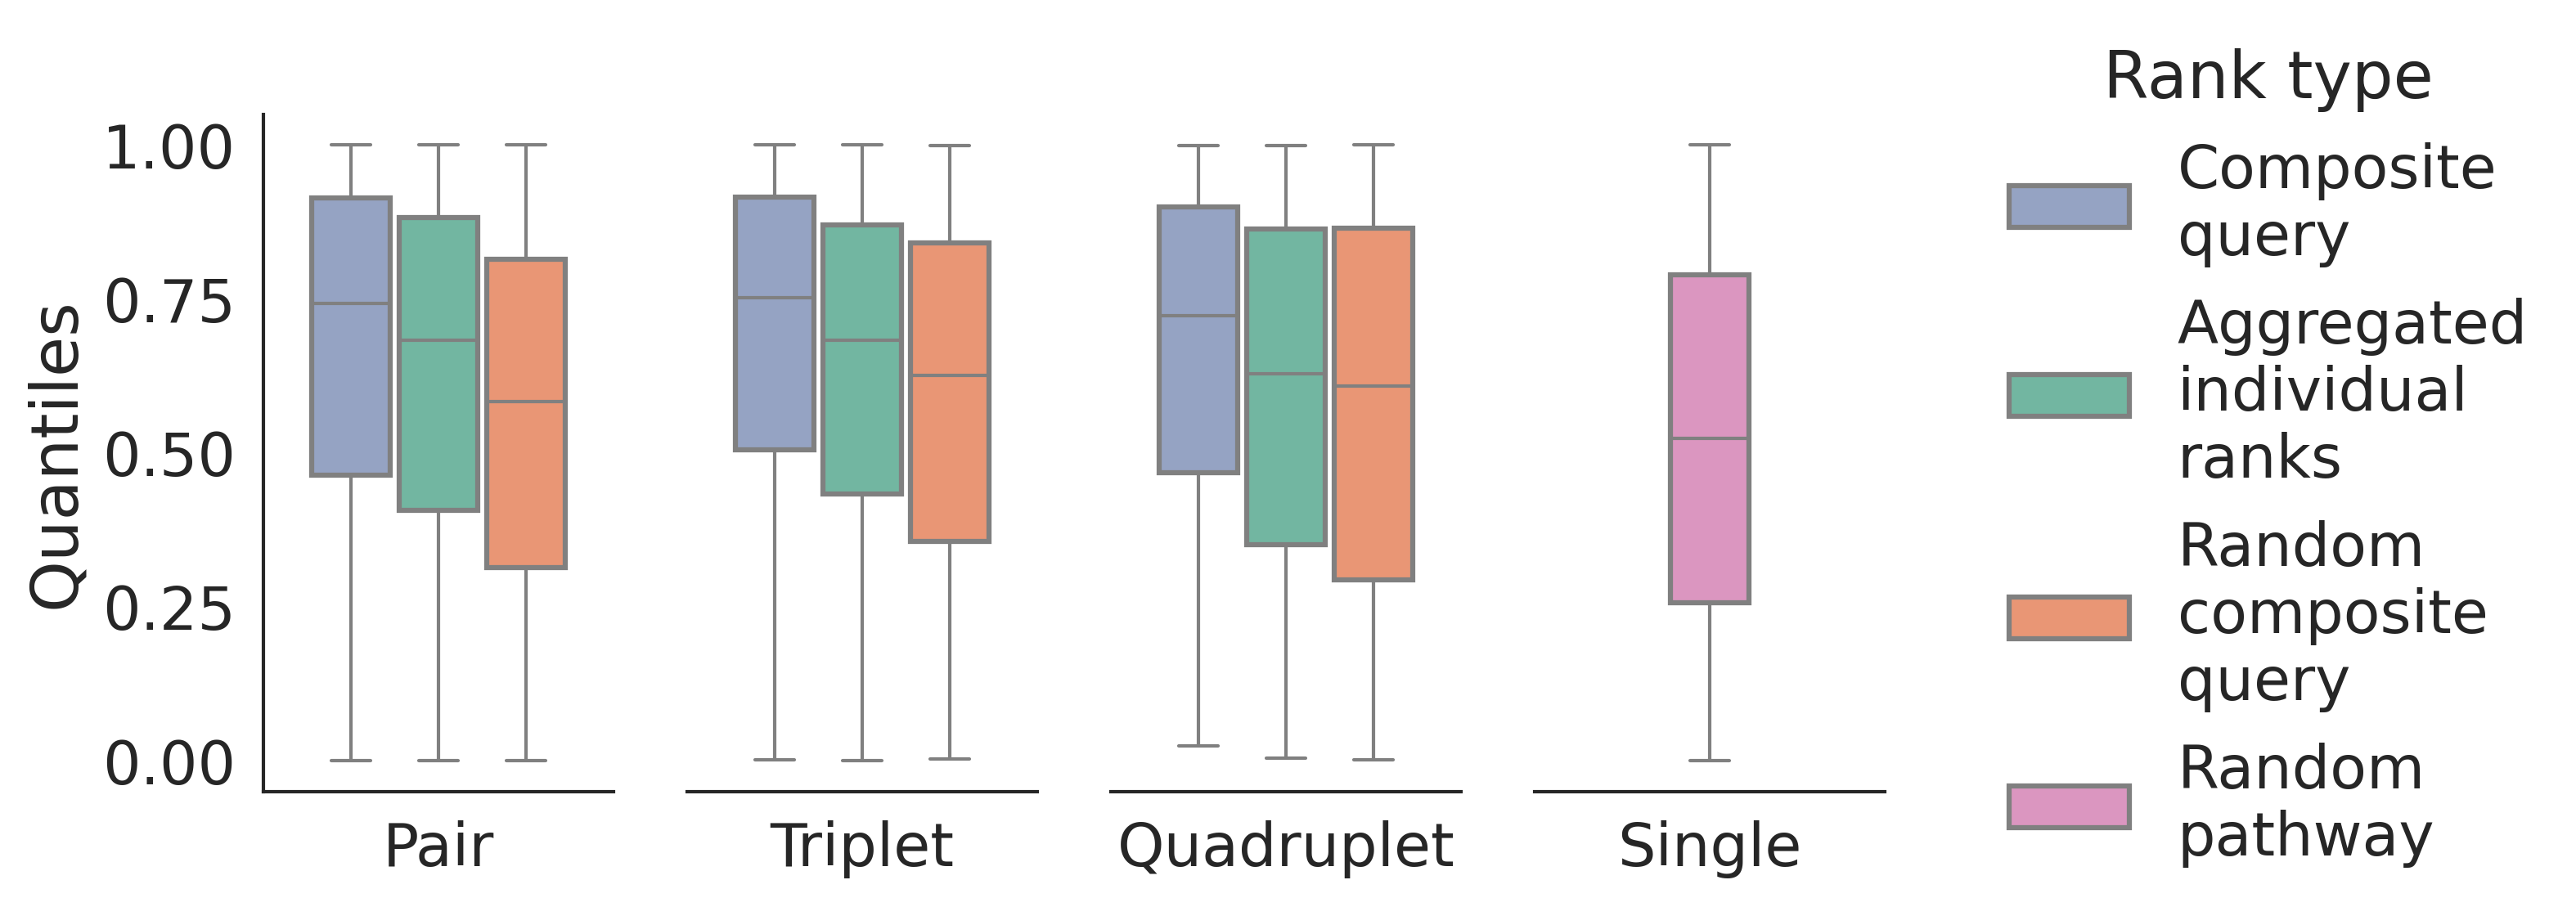

WilcoxonResult(statistic=9735240.0, pvalue=1.4182214551421512e-81)
WilcoxonResult(statistic=10508905.0, pvalue=1.7431977687592032e-150)
MannwhitneyuResult(statistic=19451313.5, pvalue=1.8291595237658599e-156)
WilcoxonResult(statistic=453986.5, pvalue=8.48479946214289e-54)
WilcoxonResult(statistic=478944.5, pvalue=9.351257037984906e-46)
MannwhitneyuResult(statistic=6482403.5, pvalue=4.64748285477337e-99)
WilcoxonResult(statistic=57238.0, pvalue=9.538115758894861e-27)
WilcoxonResult(statistic=67514.0, pvalue=1.1736596004731416e-16)
MannwhitneyuResult(statistic=2318803.5, pvalue=1.9514580182180038e-31)


In [39]:
# Custom color palette as a dictionary
colors = ['#8da0cb', '#66c2a5', '#fc8d62', '#e78ac3']
hue_names = plot_data["Rank type"].unique()
palette = dict(zip(hue_names, colors))

# Determine the unique x values and corresponding unique hues
unique_xs = plot_data["Number of processes"].unique()
hue_dict = {x: plot_data[plot_data["Number of processes"] == x]["Rank type"].unique() for x in unique_xs}

# Create subplots
fig, axes = plt.subplots(1, len(unique_xs), figsize=(8, 4), sharey=True, dpi=300)
sns.set(context="paper", font_scale=2, style="white")

# Loop through each unique x and plot individually
handles_list = []
labels_list = []
for i, x in enumerate(unique_xs):
    ax = axes[i]

    sns_plot = sns.boxplot(
        data=plot_data.query("`Number of processes` == @x"),
        x="Number of processes",
        y="Quantiles",
        hue="Rank type",
        hue_order=hue_dict[x],
        width=0.25 if i == 3 else 0.75,
        dodge=True,
        showfliers=False,
        palette=palette,
        ax=ax,
        gap=0.1,
        boxprops={"edgecolor": 'gray', "linewidth": 1.5, "linestyle": '-'},
        whiskerprops={'color': 'gray', 'linestyle': '-'},
        capprops={'color': 'gray', 'linestyle': '-'},
        medianprops={'color': 'gray', 'linestyle': '-'}
    )

    # Remove upper and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Remove left border for the last three subplots
    if i >= len(unique_xs) - 3:
        ax.spines['left'].set_visible(False)
        ax.tick_params(left=False)


    # Remove legend for individual plots
    ax.get_legend().remove()
    ax.set_xlabel("")

    # Collect handles for global legend
    if sns_plot.get_legend_handles_labels()[0]:
        handles, labels = sns_plot.get_legend_handles_labels()
        for h, l in zip(handles, labels):
            if l not in labels_list:
                handles_list.append(h)
                labels_list.append(l)

# Create a unified legend
fig.legend(handles_list, labels_list, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title="Rank type")

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust the top to make space for the legend
plt.show()

print(
    stats.wilcoxon(
        plot_data.query("`Rank type` == 'Composite\\nquery' and `Number of processes` == 'Pair'")["Quantiles"].values,
        plot_data.query("`Rank type` == 'Aggregated\\nindividual\\nranks' and `Number of processes` == 'Pair'")["Quantiles"].values,
        alternative="greater",
    )
)
print(
    stats.wilcoxon(
        plot_data.query("`Rank type` == 'Composite\\nquery' and `Number of processes` == 'Pair'")["Quantiles"].values,
        plot_data.query("`Rank type` == 'Random\\ncomposite\\nquery' and `Number of processes` == 'Pair'")["Quantiles"].values,
        alternative="greater",
    )
)
print(
    stats.mannwhitneyu(
        plot_data.query("`Rank type` == 'Composite\\nquery' and `Number of processes` == 'Pair'")["Quantiles"].values,
        plot_data.query("`Rank type` == 'Random\\npathway'")["Quantiles"].values,
        alternative="greater",
    )
)

print(
    stats.wilcoxon(
        plot_data.query("`Rank type` == 'Composite\\nquery' and `Number of processes` == 'Triplet'")["Quantiles"].values,
        plot_data.query("`Rank type` == 'Aggregated\\nindividual\\nranks' and `Number of processes` == 'Triplet'")["Quantiles"].values,
    )
)
print(
    stats.wilcoxon(
        plot_data.query("`Rank type` == 'Composite\\nquery' and `Number of processes` == 'Triplet'")["Quantiles"].values,
        plot_data.query("`Rank type` == 'Random\\ncomposite\\nquery' and `Number of processes` == 'Triplet'")["Quantiles"].values,
    )
)
print(
    stats.mannwhitneyu(
        plot_data.query("`Rank type` == 'Composite\\nquery' and `Number of processes` == 'Triplet'")["Quantiles"].values,
        plot_data.query("`Rank type` == 'Random\\npathway'")["Quantiles"].values,
        alternative="greater",
    )
)

print(
    stats.wilcoxon(
        plot_data.query("`Rank type` == 'Composite\\nquery' and `Number of processes` == 'Quadruplet'")["Quantiles"].values,
        plot_data.query("`Rank type` == 'Aggregated\\nindividual\\nranks' and `Number of processes` == 'Quadruplet'")["Quantiles"].values,
    )
)
print(
    stats.wilcoxon(
        plot_data.query("`Rank type` == 'Composite\\nquery' and `Number of processes` == 'Quadruplet'")["Quantiles"].values,
        plot_data.query("`Rank type` == 'Random\\ncomposite\\nquery' and `Number of processes` == 'Quadruplet'")["Quantiles"].values,
    )
)
print(
    stats.mannwhitneyu(
        plot_data.query("`Rank type` == 'Composite\\nquery' and `Number of processes` == 'Quadruplet'")["Quantiles"].values,
        plot_data.query("`Rank type` == 'Random\\npathway'")["Quantiles"].values,
        alternative="greater",
    )
)

In [47]:
combined_plot_data = (
    pd.concat((
        procyon_data.assign(plot_rank=lambda x: "ProCyon:\n"+x["Rank type"]),
        protst_data.assign(plot_rank=lambda x: "ProtST:\n"+x["Rank type"]),
    ))
    .drop(columns=["Rank type"])
    .rename(columns={"plot_rank": "Rank type"})
)
combined_plot_data.head()

,Quantiles,Number of processes,Rank type
0,0.897078,Pair,ProCyon:\nComposite\nquery
1,0.557472,Pair,ProCyon:\nComposite\nquery
2,0.821861,Pair,ProCyon:\nComposite\nquery
3,0.890558,Pair,ProCyon:\nComposite\nquery
4,0.715005,Pair,ProCyon:\nComposite\nquery


In [50]:
hue_names = combined_plot_data["Rank type"].unique()
hue_names


/tmp/ipykernel_1252043/3266169269.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  hue_dict = {x: combined_plot_data[plot_data["Number of processes"] == x]["Rank type"].unique() for x in unique_xs}
/tmp/ipykernel_1252043/3266169269.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  hue_dict = {x: combined_plot_data[plot_data["Number of processes"] == x]["Rank type"].unique() for x in unique_xs}
/tmp/ipykernel_1252043/3266169269.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  hue_dict = {x: combined_plot_data[plot_data["Number of processes"] == x]["Rank type"].unique() for x in unique_xs}
/tmp/ipykernel_1252043/3266169269.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  hue_dict = {x: combined_plot_data[plot_data["Number of processes"] == x]["Rank type"].unique() for x in unique_xs}


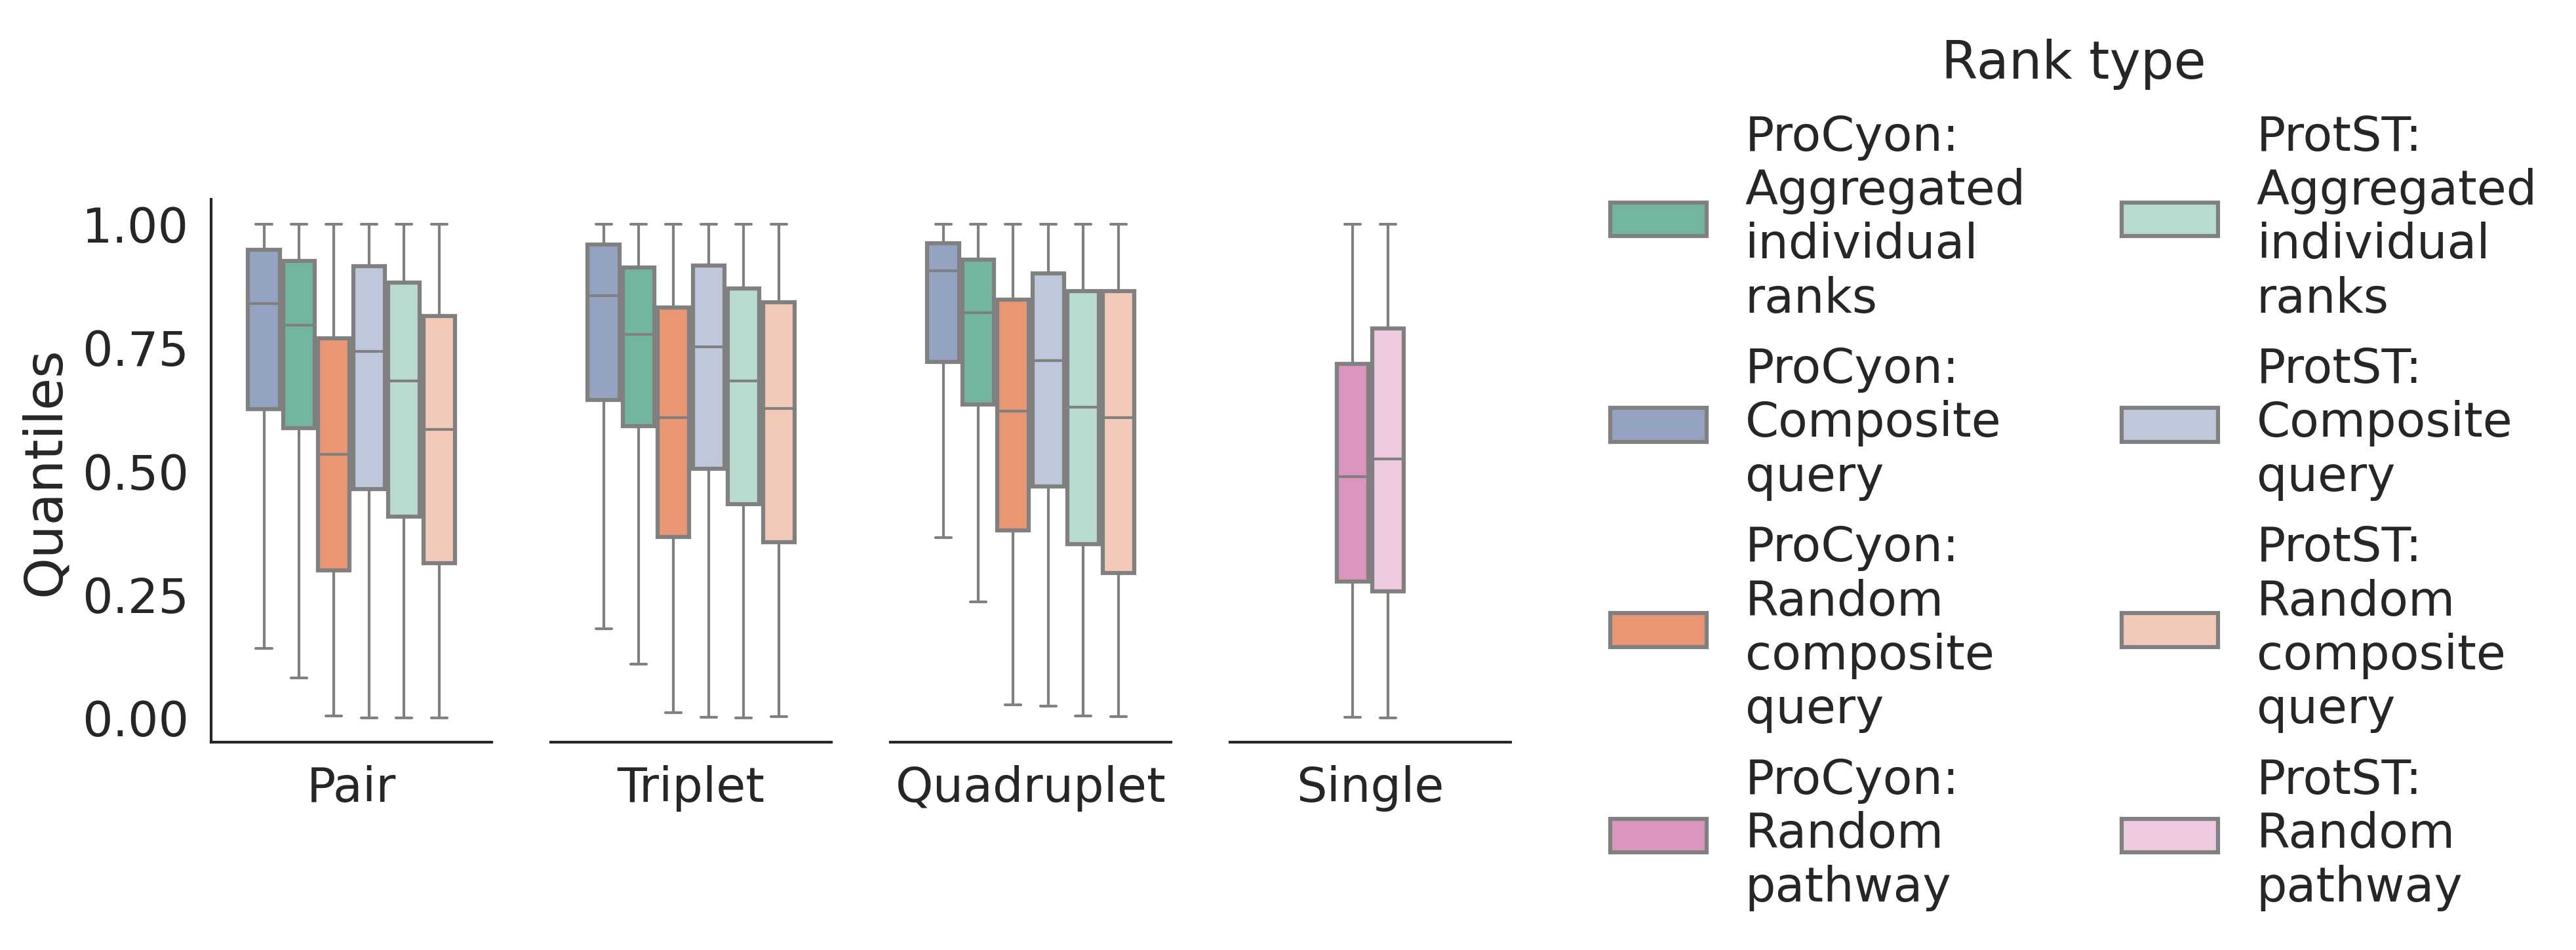

In [56]:
# Custom color palette as a dictionary
colors = [
    '#8da0cb', '#66c2a5', '#fc8d62', '#e78ac3',
    "#bac6df", "#b2e0d2", "#fdc6b0", "#f3c4e1",
]
hue_names = combined_plot_data["Rank type"].unique()
palette = dict(zip(hue_names, colors))

# Determine the unique x values and corresponding unique hues
unique_xs = combined_plot_data["Number of processes"].unique()
hue_dict = {x: combined_plot_data[plot_data["Number of processes"] == x]["Rank type"].unique() for x in unique_xs}

# Create subplots
fig, axes = plt.subplots(1, len(unique_xs), figsize=(8, 4), sharey=True, dpi=300)
sns.set(context="paper", font_scale=2, style="white")

# Loop through each unique x and plot individually
all_legend_entries =[]
seen_labels = set()
for i, x in enumerate(unique_xs):
    ax = axes[i]

    sns_plot = sns.boxplot(
        data=combined_plot_data.query("`Number of processes` == @x"),
        x="Number of processes",
        y="Quantiles",
        hue="Rank type",
        hue_order=hue_dict[x],
        width=0.25 if i == 3 else 0.75,
        dodge=True,
        showfliers=False,
        palette=palette,
        ax=ax,
        gap=0.1,
        boxprops={"edgecolor": 'gray', "linewidth": 1.5, "linestyle": '-'},
        whiskerprops={'color': 'gray', 'linestyle': '-'},
        capprops={'color': 'gray', 'linestyle': '-'},
        medianprops={'color': 'gray', 'linestyle': '-'}
    )

    # Remove upper and right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Remove left border for the last three subplots
    if i >= len(unique_xs) - 3:
        ax.spines['left'].set_visible(False)
        ax.tick_params(left=False)


    # Remove legend for individual plots
    ax.get_legend().remove()
    ax.set_xlabel("")


    if sns_plot.get_legend_handles_labels()[0]:
        handles, labels = sns_plot.get_legend_handles_labels()
        for h, l in zip(handles, labels):
            if l not in seen_labels:
                all_legend_entries.append((h,l))
                seen_labels.add(l)

all_legend_entries = sorted(all_legend_entries, key=lambda x: x[1])
handles_list, labels_list = zip(*all_legend_entries)

# Create a unified legend
fig.legend(handles_list, labels_list, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title="Rank type", ncol=2)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust the top to make space for the legend
plt.show()